In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import data_table
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [13]:
final_df = pd.read_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Data/03 Feature Selected Data/final_df_next_day_20210919_10.csv').reset_index(drop=True)
final_df

,Date,sma90 avg_transaction_value,wma30 avg_transaction_value,closing_price,dema7 opening_price,ema90 avg_transaction_value,tema30 highest_price,opening_price,tema7 closing_price,ema30 avg_transaction_value,dema90 avg_transaction_value,next_day_closing_price
0,2013-04-01,0.000000,0.001013,0.000561,0.000377,0.000000,0.000314,0.000388,0.000590,0.000750,0.000000,118.0
1,2013-04-02,0.000082,0.001185,0.000781,0.000469,0.000124,0.000409,0.000561,0.000769,0.000925,0.000180,135.0
2,2013-04-03,0.000169,0.001354,0.001049,0.000621,0.000247,0.000572,0.000781,0.001014,0.001095,0.000358,132.1
3,2013-04-04,0.000248,0.001499,0.001004,0.000833,0.000360,0.000699,0.001049,0.001111,0.001237,0.000518,142.3
4,2013-04-05,0.000328,0.001643,0.001164,0.000944,0.000474,0.000816,0.001004,0.001242,0.001377,0.000677,142.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3088,2021-09-14,0.962009,1.000000,0.740622,0.713871,0.987119,0.777173,0.707069,0.719939,1.000000,0.996045,48130.6
3089,2021-09-15,0.971827,0.992880,0.757213,0.724588,0.991312,0.776191,0.740477,0.740076,0.987087,0.996319,47748.0
3090,2021-09-16,0.982980,0.989533,0.751185,0.739332,0.997794,0.775406,0.757200,0.748003,0.979753,1.000000,47282.8
3091,2021-09-17,0.991883,0.974805,0.743856,0.746433,0.998428,0.773731,0.751149,0.747889,0.961515,0.995155,48306.7


In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

In [15]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|██████████| 26/26 [00:00<00:00, 6809.36it/s]


In [16]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='next_day_closing_price',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

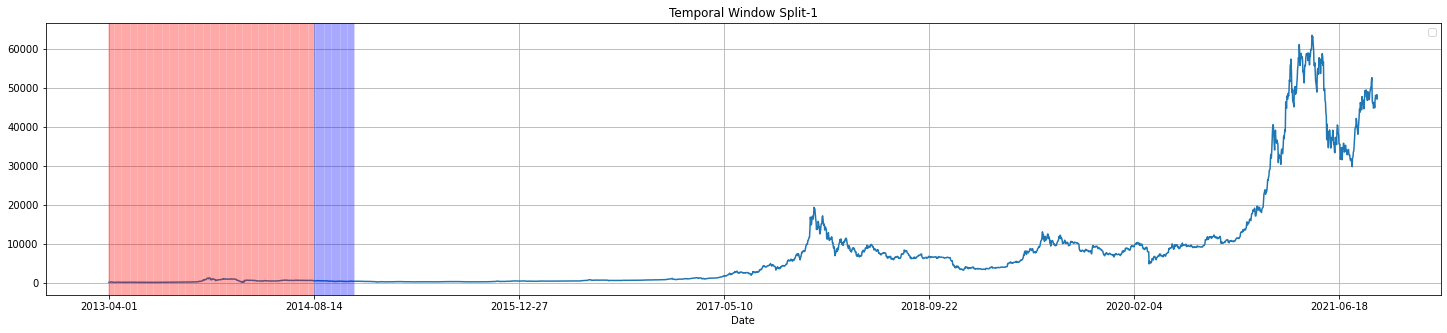

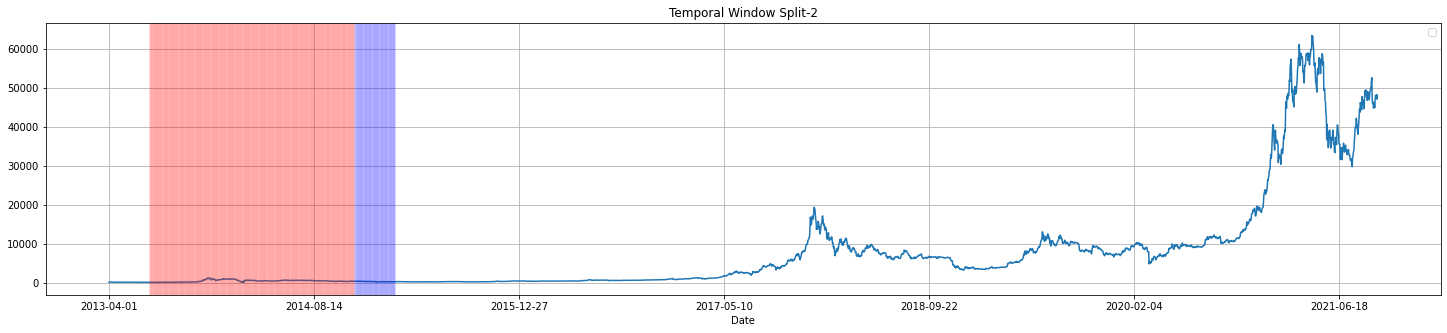

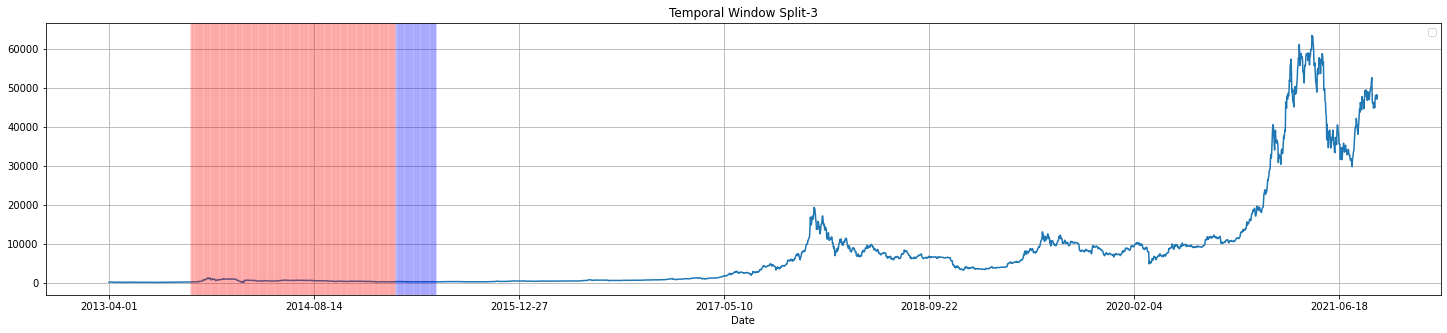

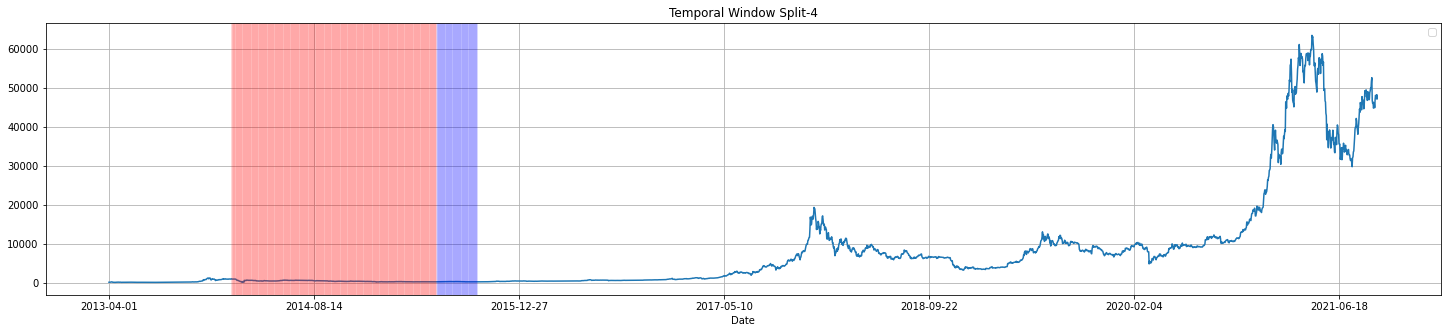

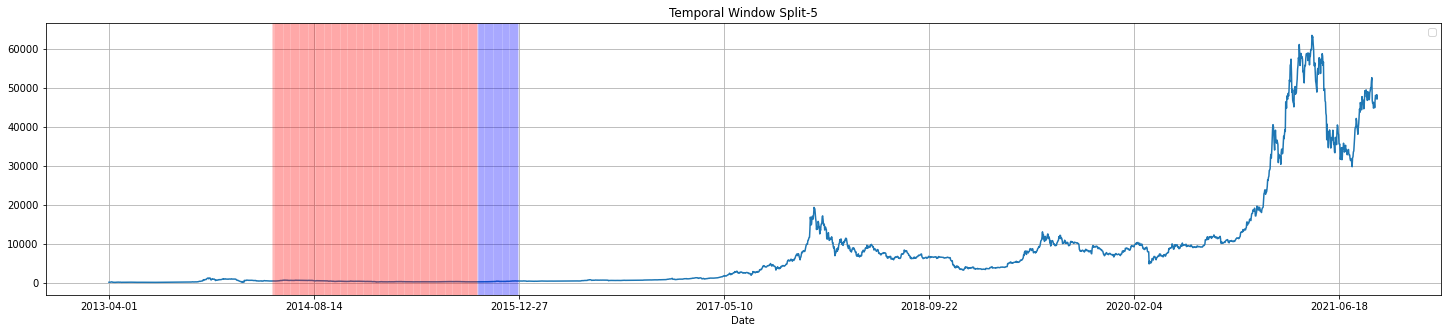

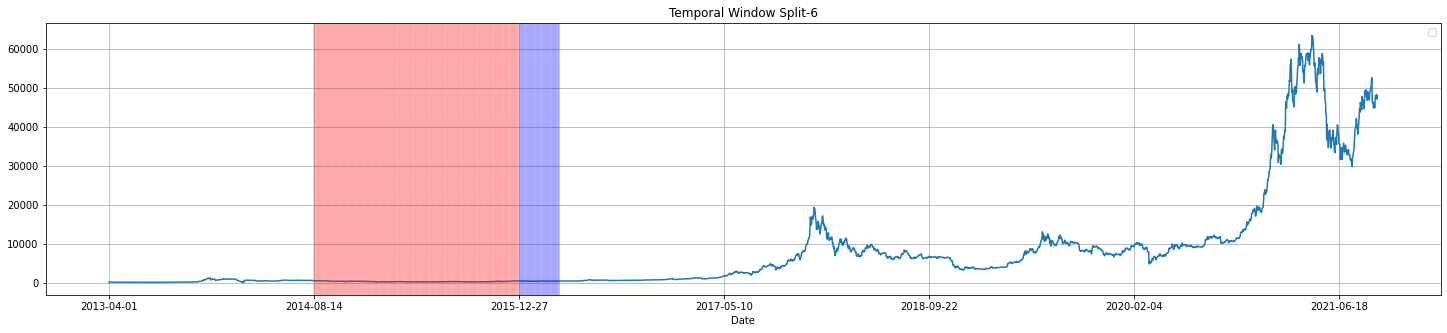

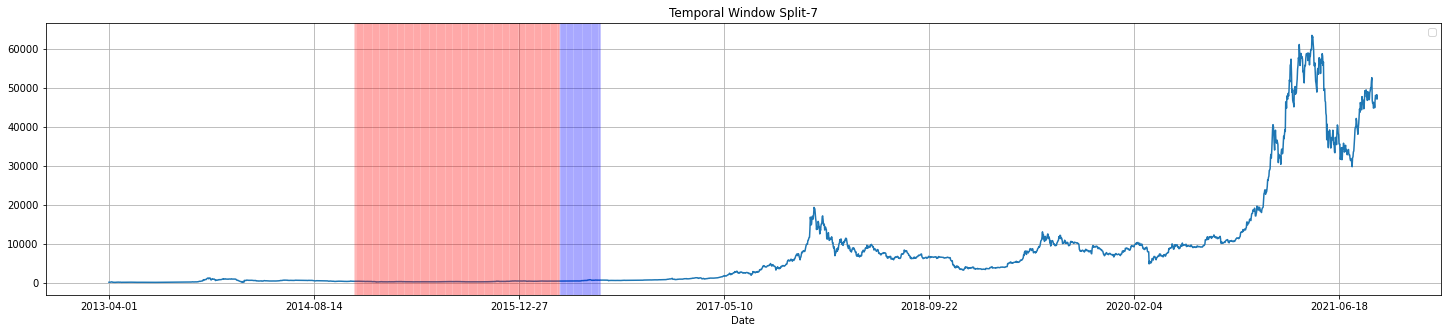

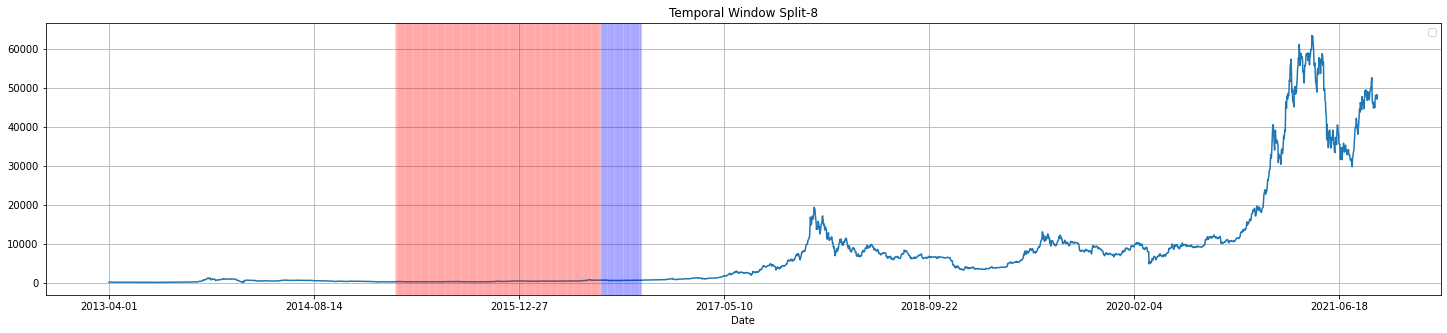

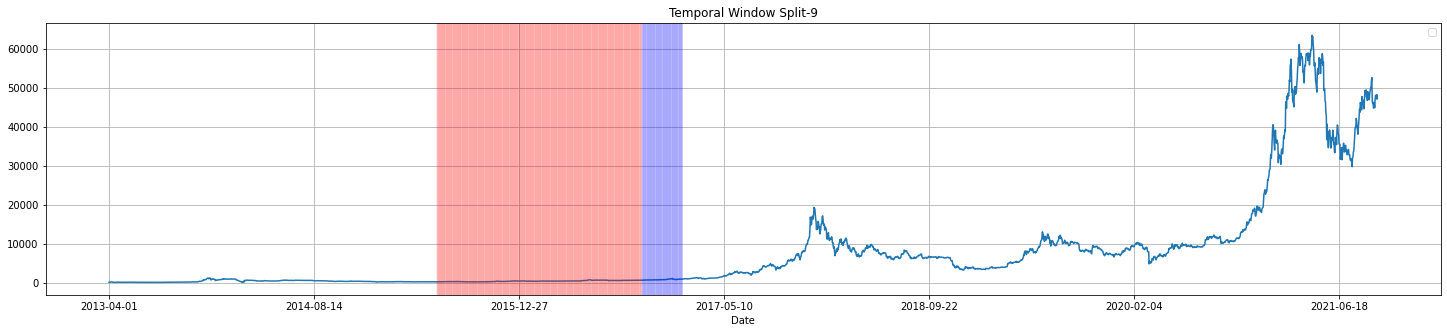

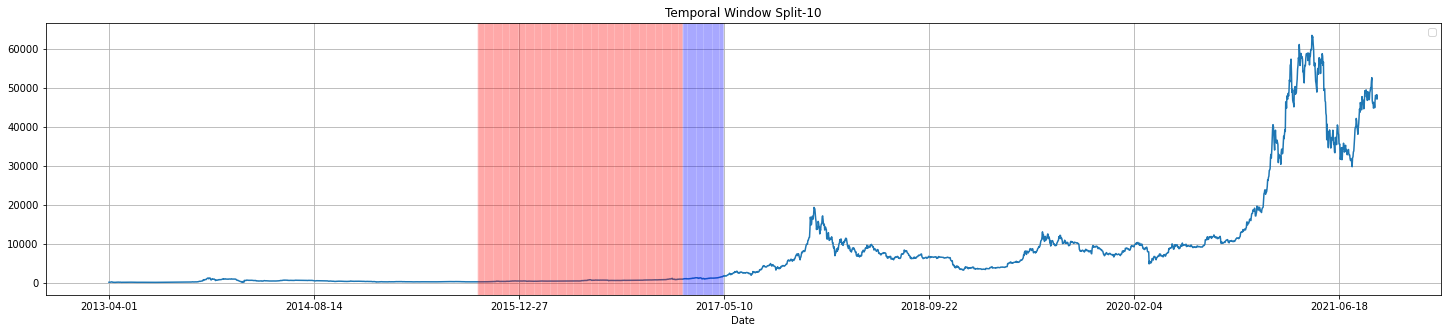

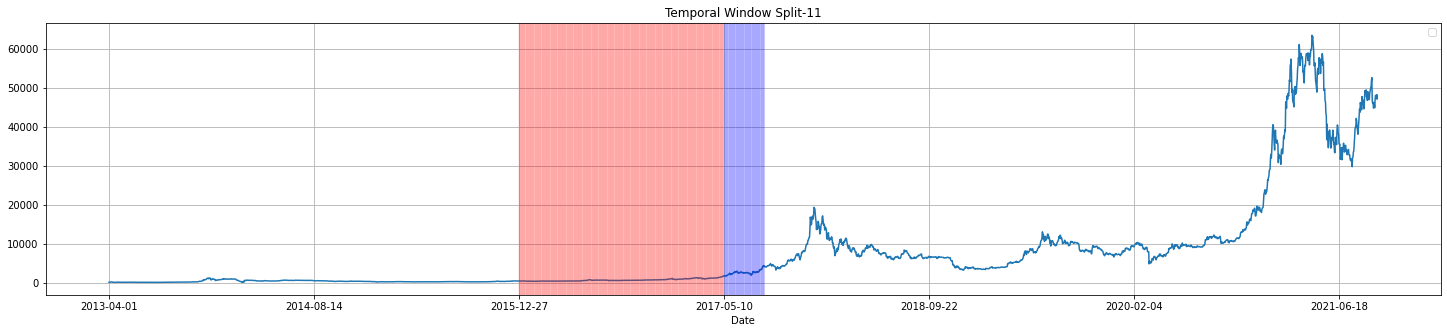

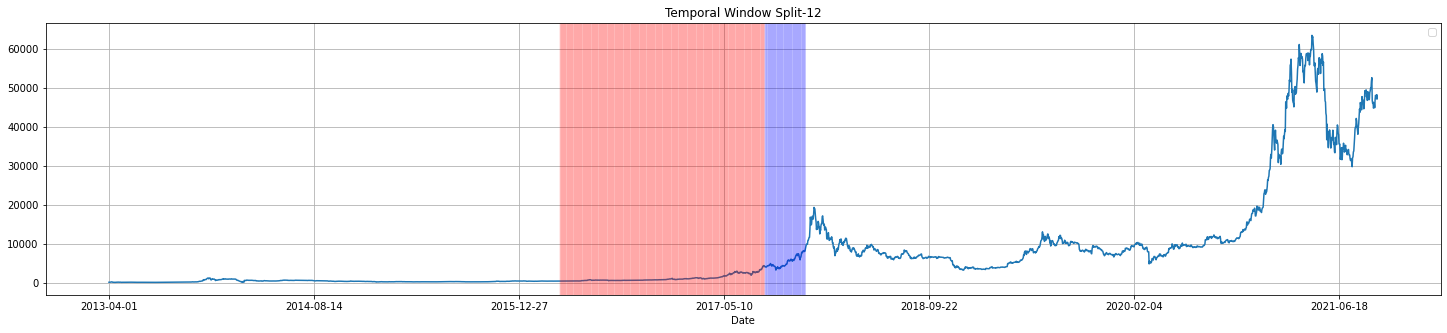

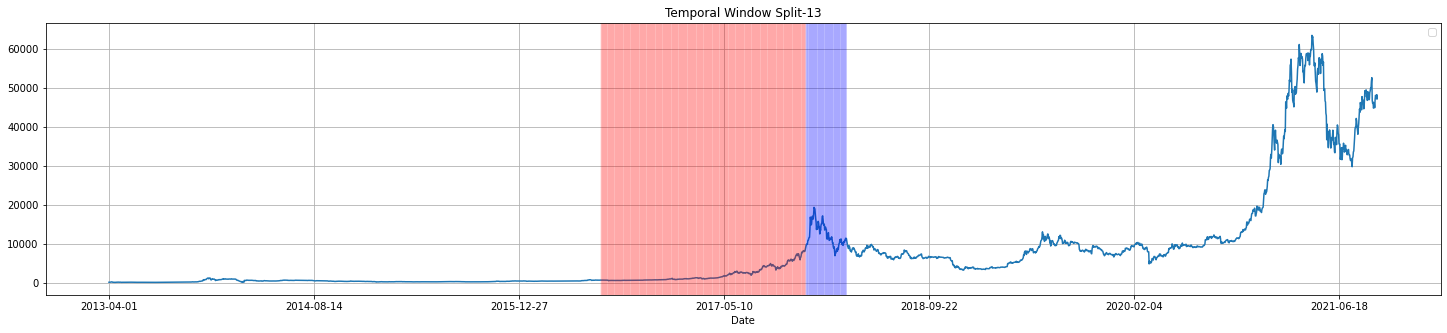

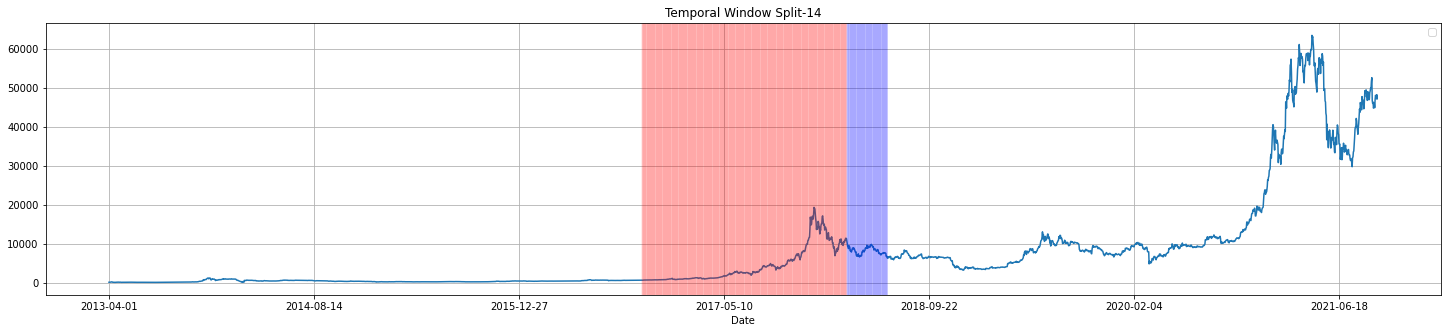

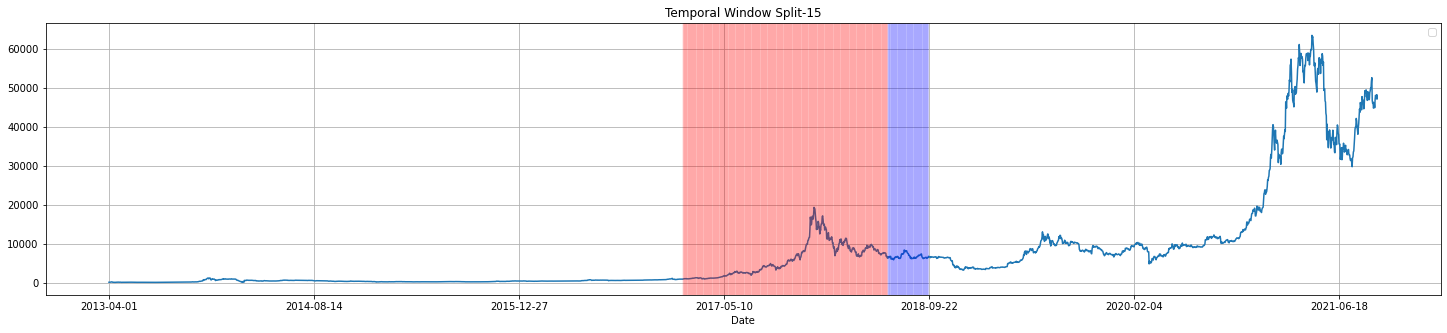

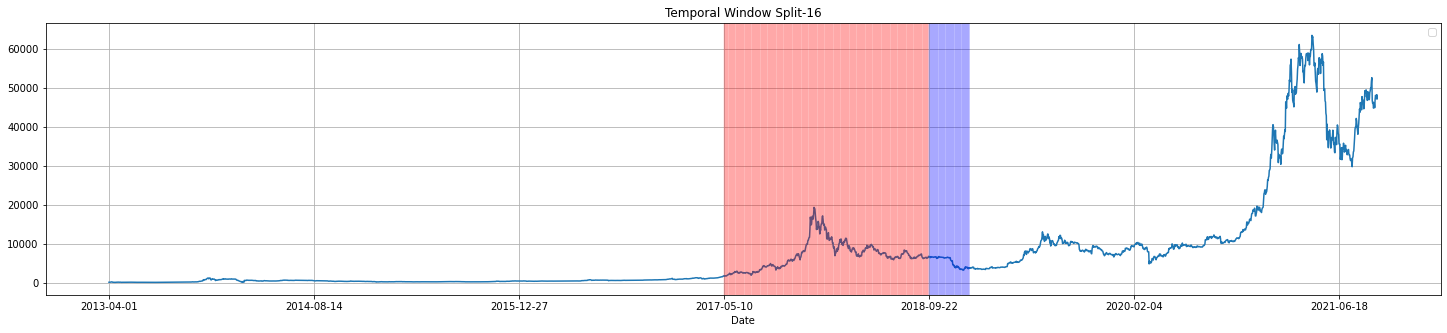

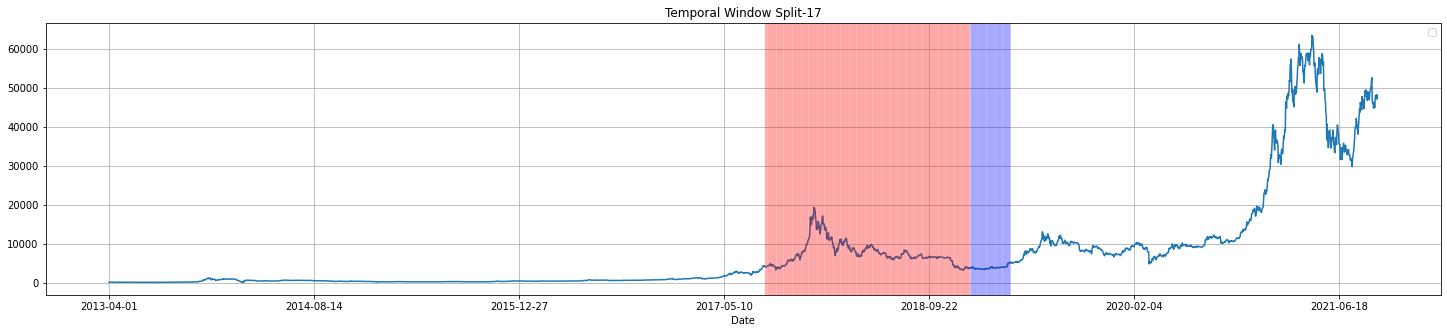

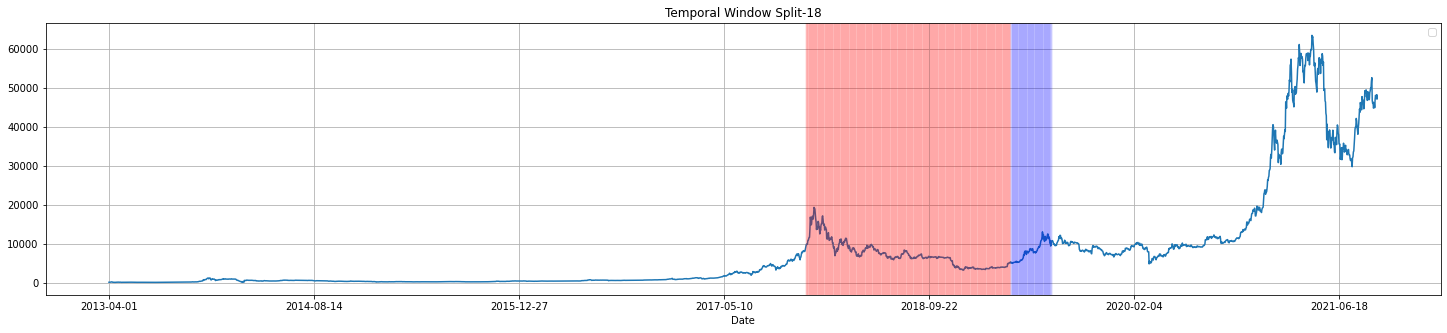

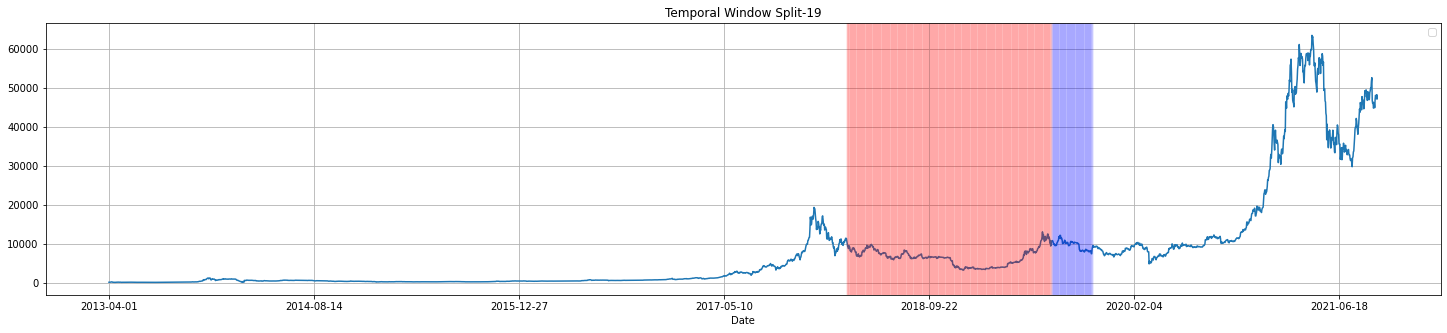

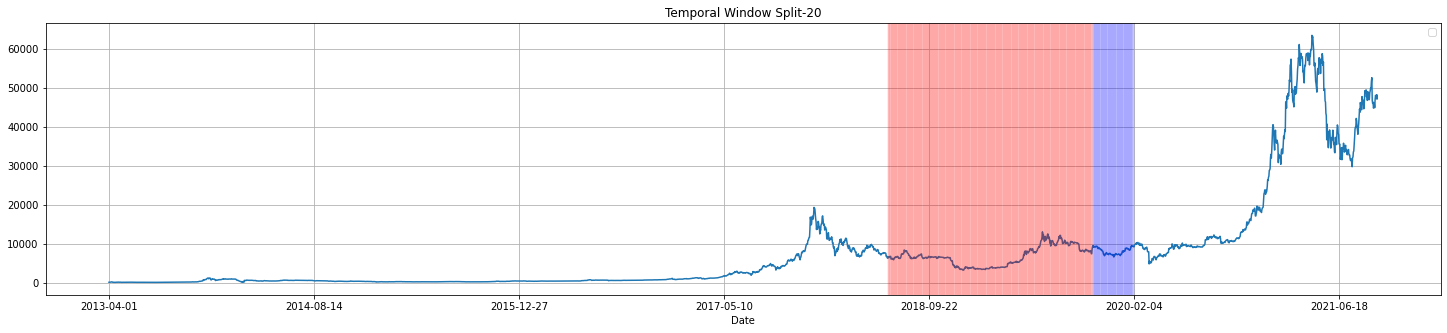

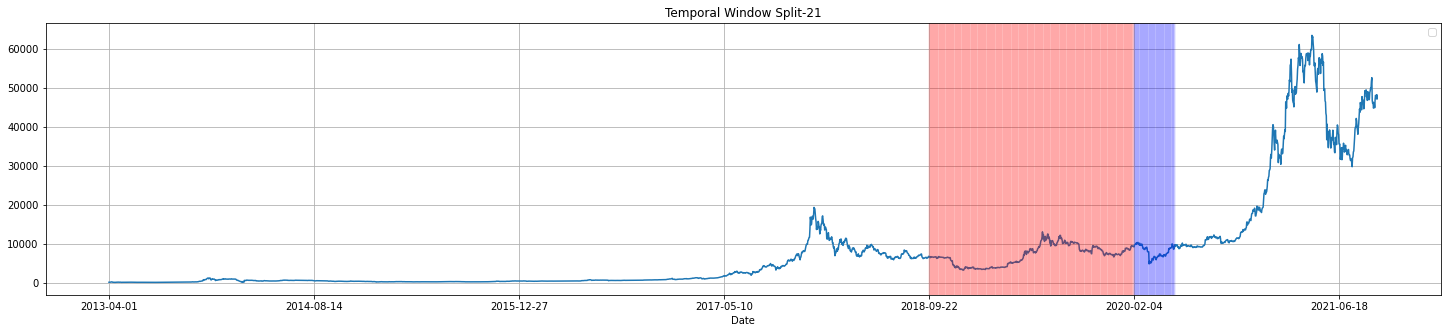

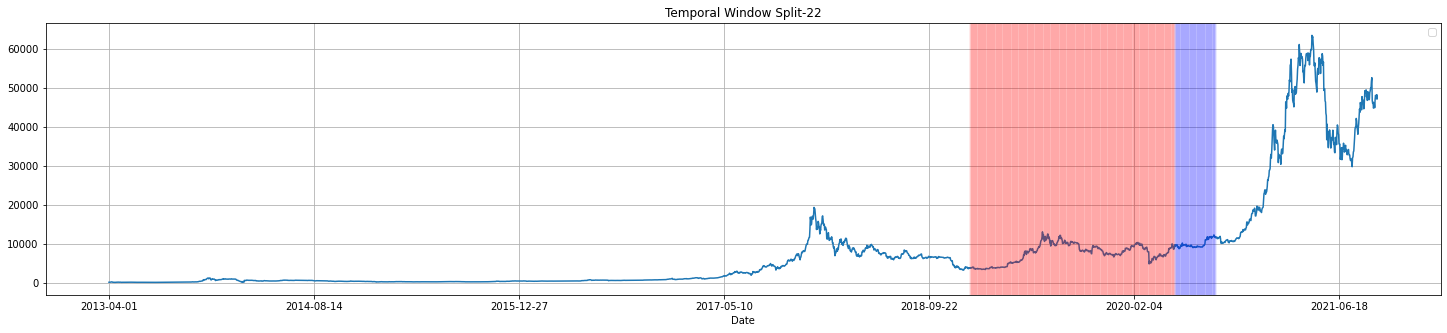

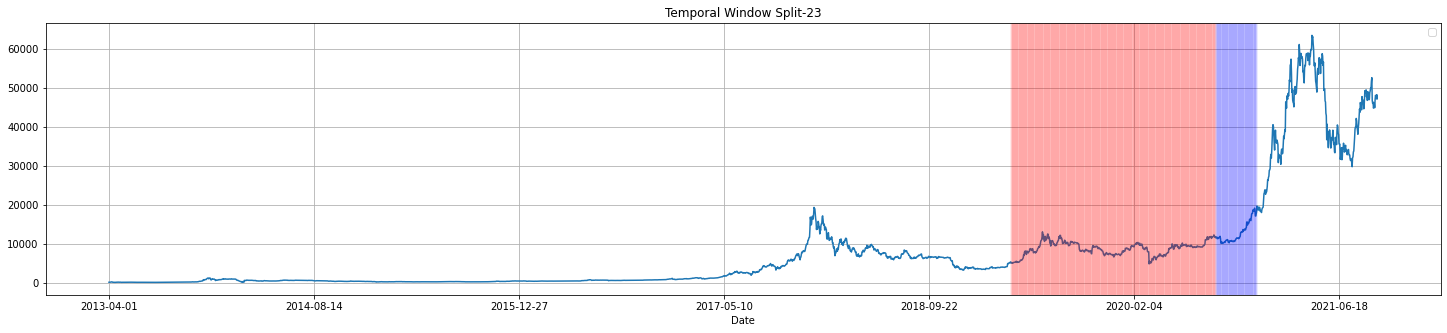

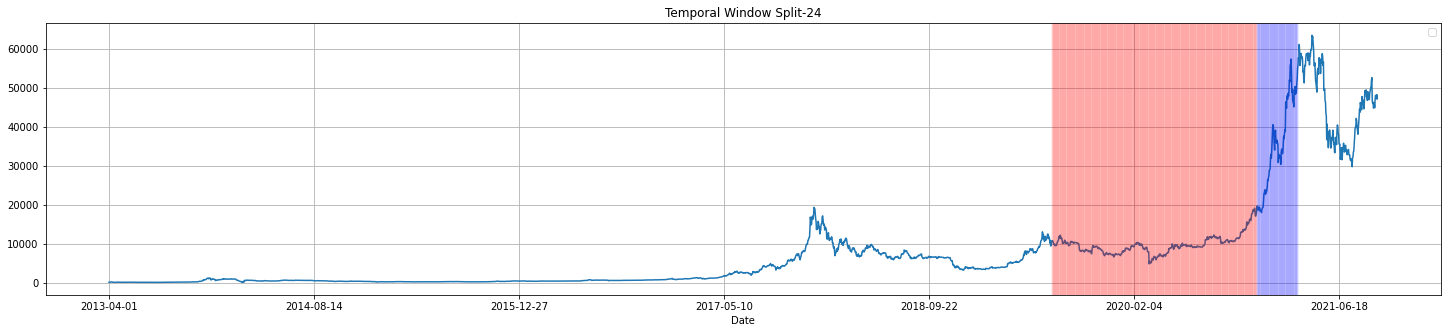

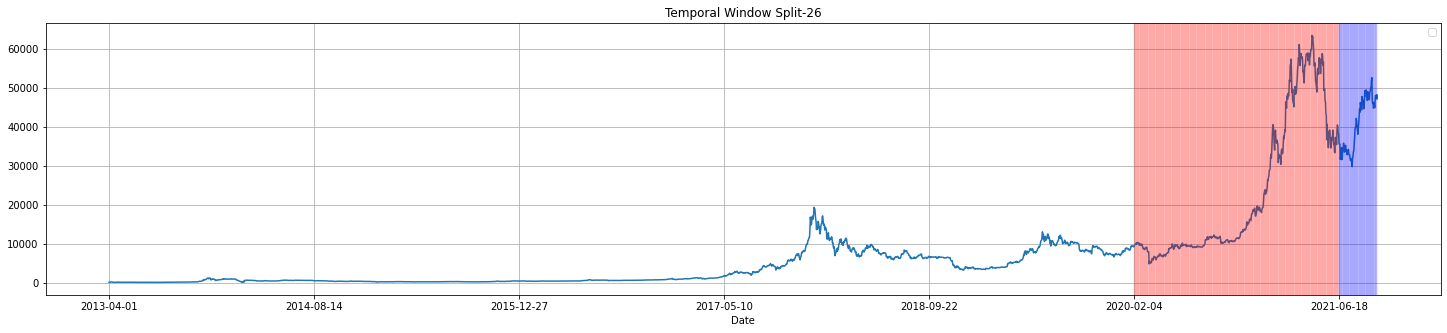

In [17]:
for i in range(len(train_splits)):
    visualize_split(i)

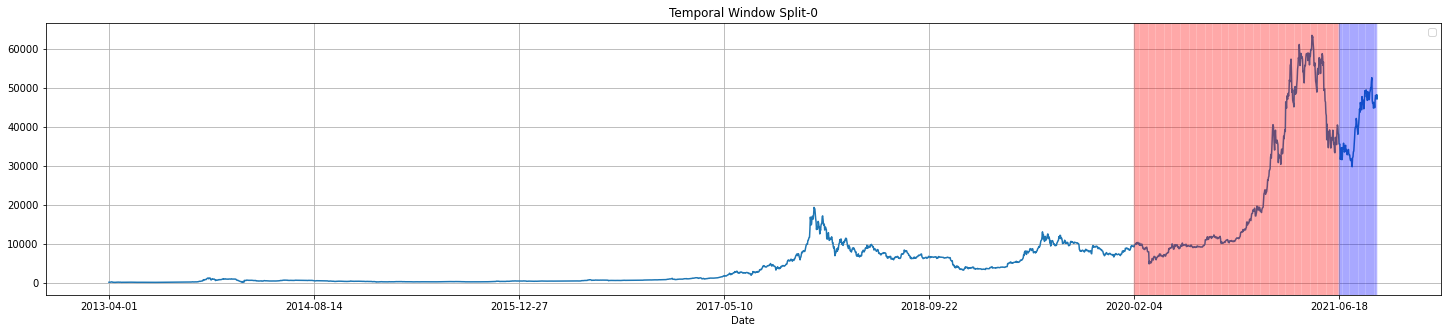

In [18]:
visualize_split(-1)

In [19]:
import shutil
shutil.make_archive('plot', 'zip', '/content/plot')

'/content/plot.zip'

In [20]:
dmy_date_array = []
dmy_y_test_array = []
dmy_y_test_pred_array = []
dmy_batch_id_array = []
dmy_batch_id_array_result = []
dmy_batch_rmse_train_array = []
dmy_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    dmy = DummyRegressor(strategy="quantile",quantile=0.9)
    dmy.fit(Xtrain_split, ytrain_split)
    pickle.dump(dmy, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Dummy Regressor/dummy_reg_10_{i}.sav', 'wb'))
    ytrain_pred = dmy.predict(Xtrain_split)
    ytest_pred = dmy.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    dmy_date_array.extend(test_splits[i]['Date'])
    dmy_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    dmy_y_test_pred_array.extend((ytest_pred.flatten()))
    dmy_batch_id_array.extend([i]*len(test_splits[i]))

    dmy_batch_id_array_result.append(i)
    dmy_batch_rmse_train_array.append(RMSE_train)

    dmy_batch_rmse_test_array.append(RMSE_test)

dmy_result_test_df = pd.DataFrame()
dmy_result_test_df['batch_id'] = dmy_batch_id_array
dmy_result_test_df['Date'] = dmy_date_array
dmy_result_test_df['y_test'] = dmy_y_test_array
dmy_result_test_df['y_test_pred'] = dmy_y_test_pred_array
dmy_y_test_array = dmy_result_test_df['y_test']
dmy_y_test_pred_array = dmy_result_test_df['y_test_pred']
dmy_result_metrics_df = pd.DataFrame()
dmy_result_metrics_df['batch_id'] = dmy_batch_id_array_result
dmy_result_metrics_df['rmse_train'] = dmy_batch_rmse_train_array
dmy_result_metrics_df['rmse_test'] = dmy_batch_rmse_test_array

100%|██████████| 26/26 [00:16<00:00,  1.60it/s]


In [21]:
pd.DataFrame(dmy_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,4680.817501
rmse_test,4344.393641


In [22]:
from sklearn.feature_selection import SelectKBest,f_regression
dmy_date_array = []
dmy_y_test_array = []
dmy_y_test_pred_array = []
dmy_batch_id_array = []
dmy_batch_id_array_result = []
dmy_batch_rmse_train_array = []
dmy_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= 5)
    # learn relationship from training data
    fs.fit(Xtrain_split, ytrain_split)
    # transform train input data
    Xtrain_split = fs.transform(Xtrain_split)
    # transform test input data
    Xtest_split = fs.transform(Xtest_split)
    # return Xtrain_split, Xtest_split, fs

    dmy = DummyRegressor(strategy="quantile",quantile=0.9)
    dmy.fit(Xtrain_split, ytrain_split)
    pickle.dump(dmy, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Dummy Regressor8/dummy_reg_10_{i}.sav', 'wb'))
    ytrain_pred = dmy.predict(Xtrain_split)
    ytest_pred = dmy.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    dmy_date_array.extend(test_splits[i]['Date'])
    dmy_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    dmy_y_test_pred_array.extend((ytest_pred.flatten()))
    dmy_batch_id_array.extend([i]*len(test_splits[i]))

    dmy_batch_id_array_result.append(i)
    dmy_batch_rmse_train_array.append(RMSE_train)
    dmy_batch_rmse_test_array.append(RMSE_test)

dmy_result_test_df = pd.DataFrame()
dmy_result_test_df['batch_id'] = dmy_batch_id_array
dmy_result_test_df['Date'] = dmy_date_array
dmy_result_test_df['y_test'] = dmy_y_test_array
dmy_result_test_df['y_test_pred'] = dmy_y_test_pred_array
dmy_y_test_array = dmy_result_test_df['y_test']
dmy_y_test_pred_array = dmy_result_test_df['y_test_pred']
dmy_result_metrics_df = pd.DataFrame()
dmy_result_metrics_df['batch_id'] = dmy_batch_id_array_result
dmy_result_metrics_df['rmse_train'] = dmy_batch_rmse_train_array
dmy_result_metrics_df['rmse_test'] = dmy_batch_rmse_test_array

100%|██████████| 26/26 [00:15<00:00,  1.71it/s]


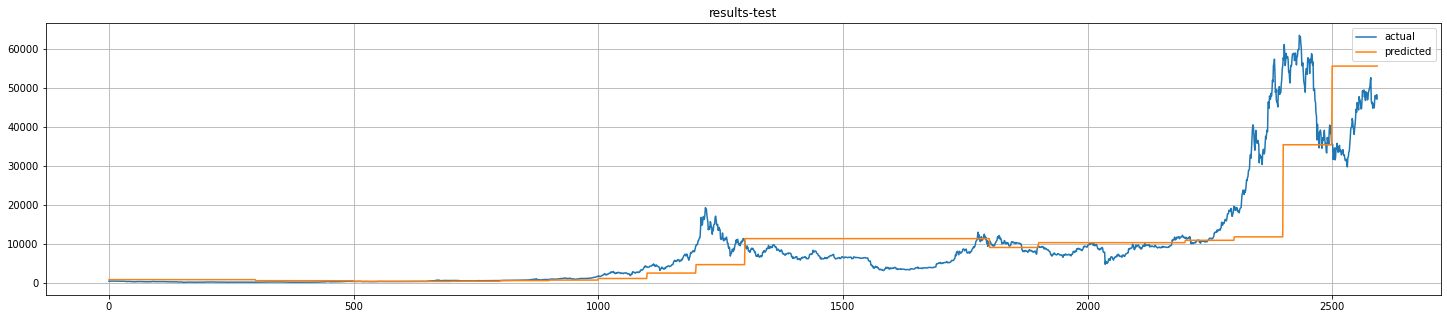

In [23]:
plot_results(dmy_y_test_array,dmy_y_test_pred_array,'results-test')

In [24]:
pd.DataFrame(dmy_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,4680.817501
rmse_test,4344.393641


In [25]:
dmy_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/dmy_result_test_20210922.csv')
dmy_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/dmy_result_metrics_20210922.csv')

SVR

In [26]:
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_rmse_train_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)
    pickle.dump(svr, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Support Vector/SVR_10_{i}.sav', 'wb'))
    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


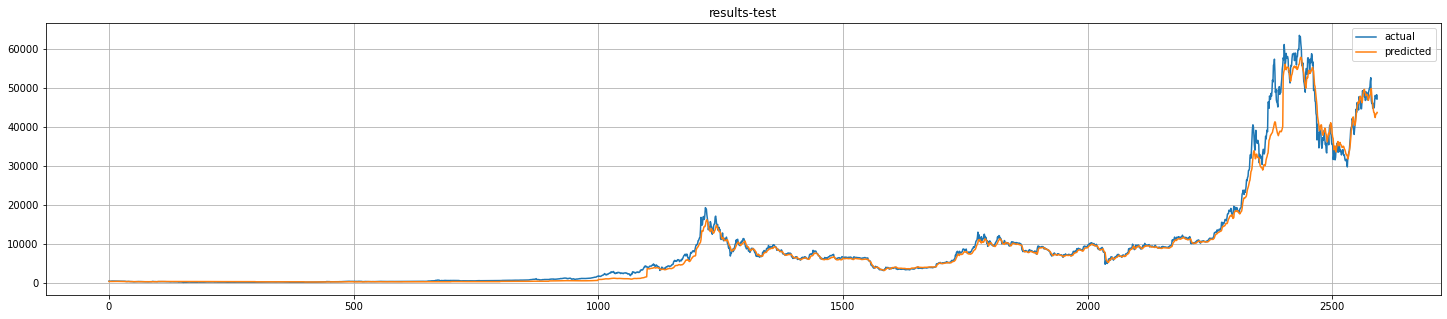

In [27]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [28]:
svr_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,143.137339,47.589100
1,1,151.550344,107.562541
2,2,146.425888,130.778461
3,3,118.019405,83.626687
4,4,113.764954,56.673283
5,5,70.804247,84.732816
6,6,52.430544,228.408946
7,7,95.314978,239.792159
8,8,119.221376,355.841261
9,9,157.757281,598.117689


In [29]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
rmse_train,380.781326
rmse_test,898.226368


In [30]:
# select 8 features only #
from sklearn.feature_selection import SelectKBest,f_regression
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_rmse_train_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= 8)
    # learn relationship from training data
    fs.fit(Xtrain_split, ytrain_split)
    # transform train input data
    Xtrain_split = fs.transform(Xtrain_split)
    # transform test input data
    Xtest_split = fs.transform(Xtest_split)
    # return Xtrain_split, Xtest_split, fs

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)
    pickle.dump(svr, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Support Vector8/SVR_10_{i}.sav', 'wb'))
    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


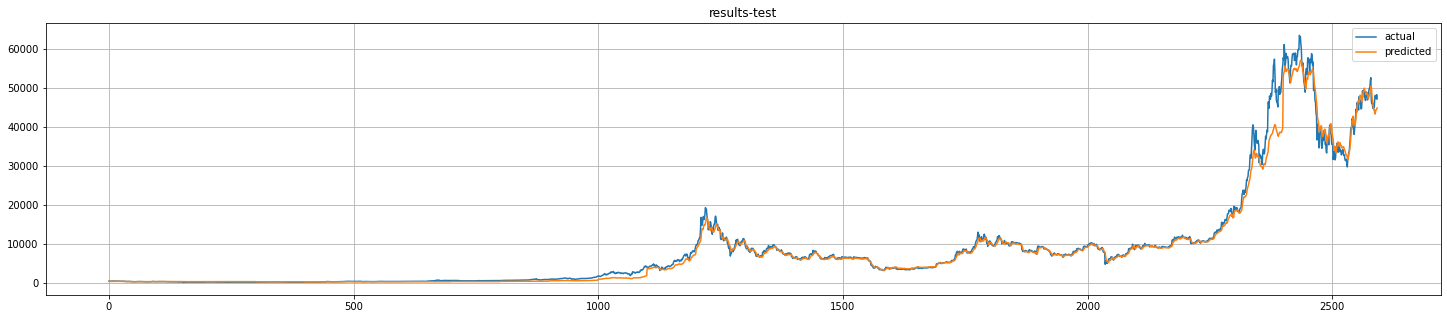

In [31]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [32]:
svr_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,137.428494,38.201056
1,1,146.009648,107.152272
2,2,142.837075,137.422675
3,3,119.751054,86.766366
4,4,113.882402,57.338319
5,5,70.253582,87.974640
6,6,50.223816,219.613014
7,7,91.175338,228.984903
8,8,114.212760,343.305355
9,9,148.178993,561.465318


In [33]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
rmse_train,365.068916
rmse_test,862.353332


In [34]:
svr_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/svr_result_test_20210922.csv')
svr_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/svr_result_metrics_20210922.csv')

XGB

In [36]:
import joblib
#from sklearn.externals import joblib
xgb_date_array = []
xgb_y_test_array = []
xgb_y_test_pred_array = []
xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []
for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    xgbm_reg.fit(Xtrain_split, ytrain_split)
    #pickle.dump(xgbm_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/XGB_10_{i}.dat', 'wb'))

    xgbm_reg.save_model(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/model_{i}.bin')
    #joblib.dump(xgbm_reg,  open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/XGB_10_{i}.joblib.dat', 'wb'))
    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array
xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']
xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


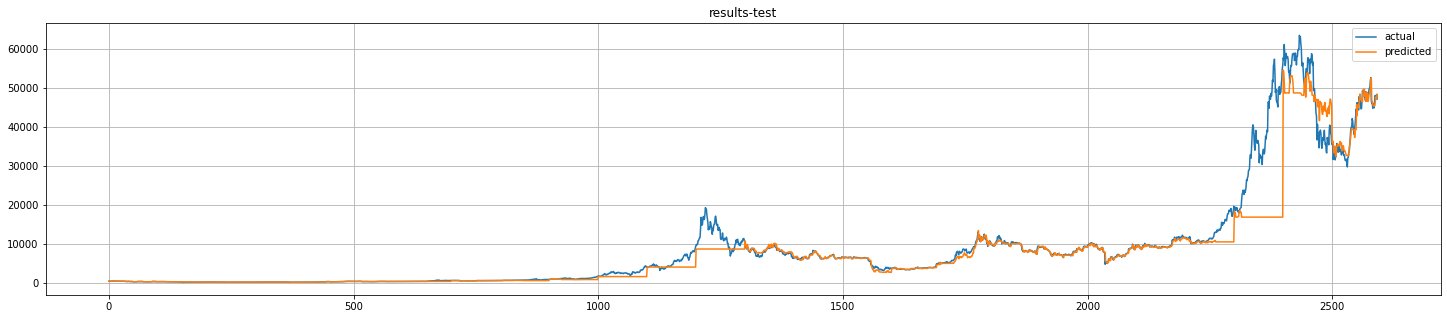

In [37]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [38]:
xgb_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,24.238506,29.717457
1,1,24.609204,38.649179
2,2,24.640823,8.373208
3,3,13.997975,8.924934
4,4,8.190570,19.392912
5,5,7.505420,11.269503
6,6,6.761919,150.727908
7,7,7.164985,37.996282
8,8,8.761568,193.017042
9,9,12.299380,307.717349


In [39]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,170.269359
rmse_test,1829.442555


In [41]:
# select 8 features only
from sklearn.feature_selection import SelectKBest,f_regression
import joblib
#from sklearn.externals import joblib
xgb_date_array = []
xgb_y_test_array = []
xgb_y_test_pred_array = []
xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []
for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= 8)
    # learn relationship from training data
    fs.fit(Xtrain_split, ytrain_split)
    # transform train input data
    Xtrain_split = fs.transform(Xtrain_split)
    # transform test input data
    Xtest_split = fs.transform(Xtest_split)
    # return Xtrain_split, Xtest_split, fs

    xgbm_reg.fit(Xtrain_split, ytrain_split)
    #pickle.dump(xgbm_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/XGB_10_{i}.dat', 'wb'))

    xgbm_reg.save_model(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/model_{i}.bin')
    #joblib.dump(xgbm_reg,  open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/XGB/XGB_10_{i}.joblib.dat', 'wb'))
    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array
xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']
xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


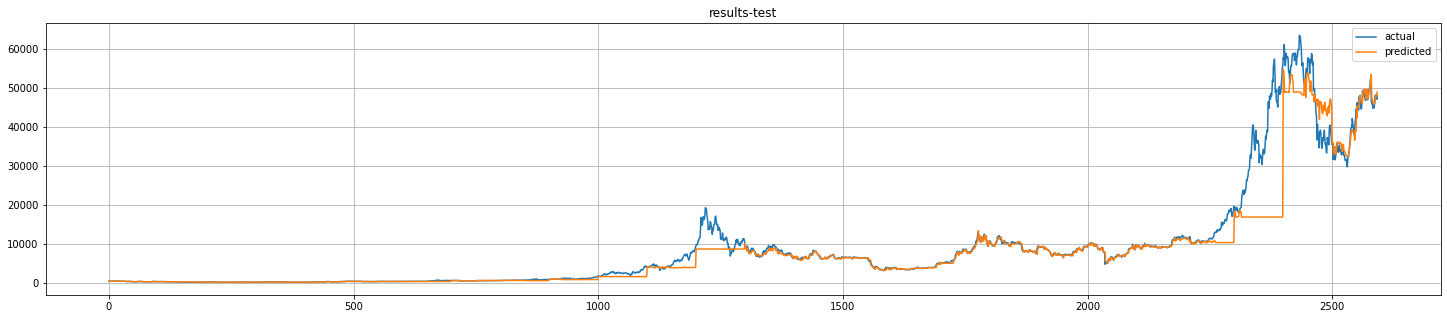

In [42]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [43]:
xgb_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,24.542493,29.636208
1,1,25.418238,43.465578
2,2,26.218863,6.981532
3,3,14.034275,9.027875
4,4,8.311901,18.081763
5,5,7.579152,12.919933
6,6,6.825747,167.003460
7,7,7.209083,38.871679
8,8,8.825451,190.024126
9,9,12.420472,305.845409


In [44]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,174.057382
rmse_test,1810.491380


In [45]:
xgb_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/xgb_result_test_20210922.csv')
xgb_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/xgb_result_metrics_20210922.csv')

Linear Regression

In [46]:
 Xtrain_split[0]

array([0.02752474, 0.14377092, 0.14834122, 0.15293289, 0.14537981,
       0.14526364, 0.02859797, 0.02663439])

In [48]:
# Select 8 features only #
from sklearn.feature_selection import SelectKBest,f_regression
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_rmse_train_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values


    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k= 8)
    # learn relationship from training data
    fs.fit(Xtrain_split, ytrain_split)
    # transform train input data
    Xtrain_split = fs.transform(Xtrain_split)
    # transform test input data
    Xtest_split = fs.transform(Xtest_split)
    # return Xtrain_split, Xtest_split, fs

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    pickle.dump(sgd_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Linear Regression Model8/linear_reg_10_{i}.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


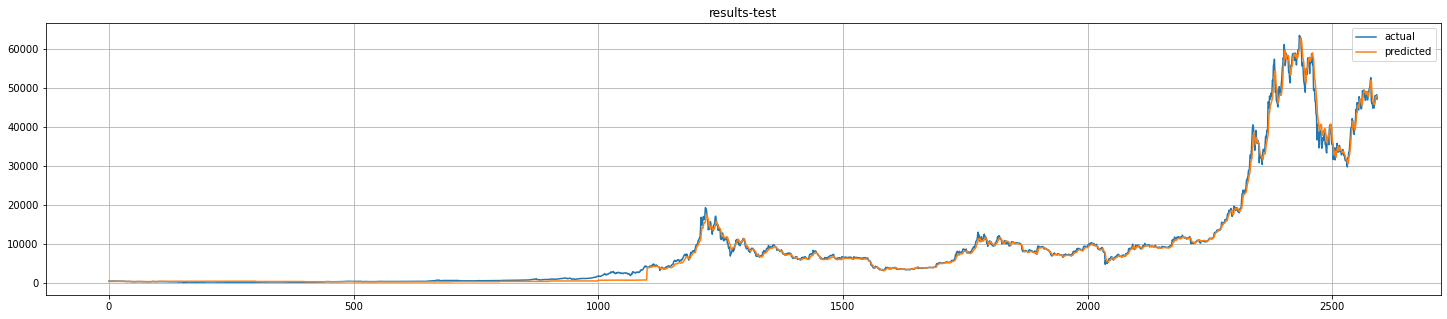

In [49]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [50]:
lr_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,203.982646,45.489772
1,1,232.109448,177.982040
2,2,203.964805,238.685183
3,3,161.394354,156.429122
4,4,136.305907,78.778699
5,5,80.079323,108.156495
6,6,74.682136,253.910816
7,7,123.111188,255.502559
8,8,143.167991,388.535515
9,9,180.507187,654.384420


In [51]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,384.753853
rmse_test,675.995704


In [52]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_rmse_train_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    pickle.dump(sgd_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Linear Regression Model/linear_reg_10_{i}.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


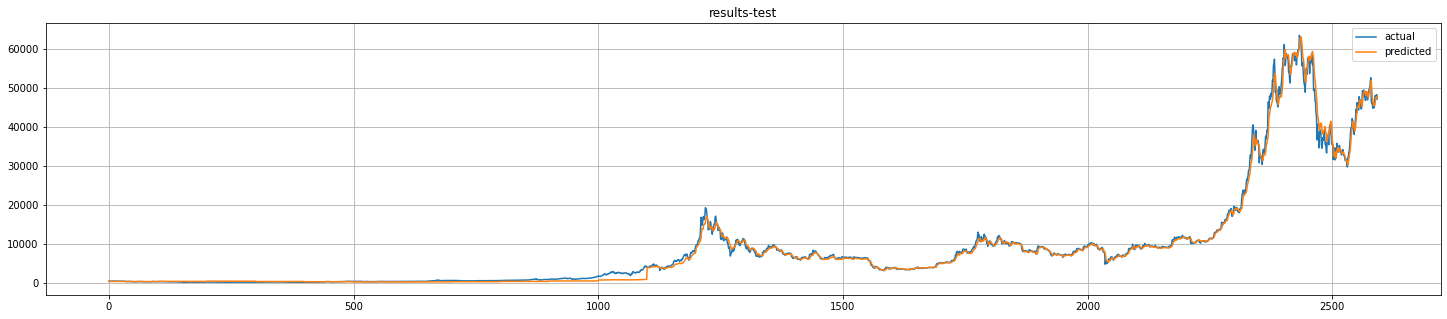

In [53]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [54]:
lr_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,203.091528,45.523959
1,1,210.876576,161.164220
2,2,212.623200,249.459055
3,3,161.946076,156.912213
4,4,136.250074,78.716953
5,5,79.932007,107.546190
6,6,74.702965,254.139424
7,7,123.235824,255.825443
8,8,143.171498,388.569173
9,9,180.449870,654.116447


In [55]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
rmse_train,380.032129
rmse_test,686.592131


In [56]:
lr_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_test_20210922.csv')
lr_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_metrics_20210922.csv')

LSTM

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

In [58]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [59]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [60]:
callback_list=[reduce_lr,lrschedule,earlystop]

In [61]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = LSTM(500, return_sequences=True,activation='relu',name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)
output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [62]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            657600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 500)            1802000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              501       
                                                                 
Total params: 2,460,101
Trainable params: 2,460,101
Non-train

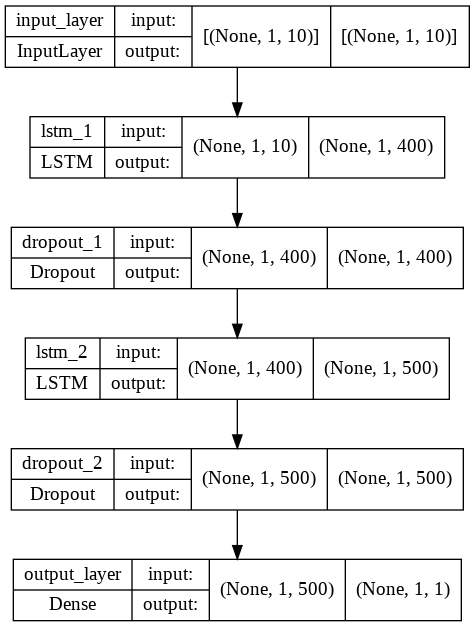

In [63]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [65]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_rmse_train_array = []
lstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    pickle.dump(model, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/LSTM1/LSTM_10_{i}.sav', 'wb'))
    model.save(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/LSTM/lstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lstm_date_array.extend(test_splits[i]['Date'])
    lstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(test_splits[i]))

    lstm_batch_id_array_result.append(i)

    lstm_batch_rmse_train_array.append(RMSE_train)
   
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']
lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array

Batch No. 1 of 26
Train Data From 2013-04-01 - 68.4 to 2014-08-13 - 1237.6
Test Data From 2014-08-14 - 322.5 to 2014-11-21 - 522.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 258.2827 - root_mean_squared_error: 296.4437 - lr: 0.0010 - 2s/epoch - 125ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 258.5198 - root_mean_squared_error: 296.4773 - lr: 0.0010 - 505ms/epoch - 32ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 258.6728 - root_mean_squared_error: 296.7170 - lr: 0.0010 - 480ms/epoch - 30ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 258.9006 - root_mean_squared_error: 295.6921 - lr: 0.0010 - 482ms/epoch - 30ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0009800000465475024.
Epoch 5/500
16/16 - 0s - lo

****************************************************************************************************
Batch No. 2 of 26
Train Data From 2013-07-10 - 89.0 to 2014-11-21 - 1237.6
Test Data From 2014-11-22 - 164.9 to 2015-03-01 - 380.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 207.4270 - root_mean_squared_error: 261.8766 - lr: 0.0010 - 3s/epoch - 168ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 205.7086 - root_mean_squared_error: 258.8486 - lr: 0.0010 - 778ms/epoch - 49ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 205.6611 - root_mean_squared_error: 259.1599 - lr: 0.0010 - 489ms/epoch - 31ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 205.4531 - root_mean_squared_error: 258.7319 - lr: 0.0010 - 510ms/epoch - 32ms/step

Epoch

****************************************************************************************************
Batch No. 3 of 26
Train Data From 2013-10-18 - 111.6 to 2015-03-01 - 1237.6
Test Data From 2015-03-02 - 218.0 to 2015-06-09 - 295.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 173.1097 - root_mean_squared_error: 223.2486 - lr: 0.0010 - 2s/epoch - 128ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 172.9968 - root_mean_squared_error: 225.5487 - lr: 0.0010 - 512ms/epoch - 32ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 173.3962 - root_mean_squared_error: 225.5420 - lr: 0.0010 - 514ms/epoch - 32ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 173.5917 - r

****************************************************************************************************
Batch No. 4 of 26
Train Data From 2014-01-26 - 111.6 to 2015-06-09 - 953.3
Test Data From 2015-06-10 - 211.4 to 2015-09-17 - 310.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 141.6101 - root_mean_squared_error: 168.2894 - lr: 0.0010 - 2s/epoch - 135ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 136.0668 - root_mean_squared_error: 165.1622 - lr: 0.0010 - 537ms/epoch - 34ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 136.0122 - root_mean_squared_error: 167.3049 - lr: 0.0010 - 572ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 135.6678 - root_mean_squared_error: 166.1671 - lr: 0.0010 - 545ms/epoch - 34ms/step

Epoch

****************************************************************************************************
Batch No. 5 of 26
Train Data From 2014-05-06 - 164.9 to 2015-09-17 - 669.4
Test Data From 2015-09-18 - 226.3 to 2015-12-26 - 463.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 120.0839 - root_mean_squared_error: 142.4636 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 110.0166 - root_mean_squared_error: 145.2276 - lr: 0.0010 - 548ms/epoch - 34ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 109.5176 - root_mean_squared_error: 150.4066 - lr: 0.0010 - 561ms/epoch - 35ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 109.9822 - ro

****************************************************************************************************
Batch No. 6 of 26
Train Data From 2014-08-14 - 164.9 to 2015-12-26 - 522.0
Test Data From 2015-12-27 - 368.0 to 2016-04-04 - 457.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 66.0272 - root_mean_squared_error: 84.0838 - lr: 0.0010 - 4s/epoch - 258ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 65.2249 - root_mean_squared_error: 88.4667 - lr: 0.0010 - 800ms/epoch - 50ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 64.7342 - root_mean_squared_error: 86.7924 - lr: 0.0010 - 840ms/epoch - 53ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 64.7826 - root_mean

****************************************************************************************************
Batch No. 7 of 26
Train Data From 2014-11-22 - 164.9 to 2016-04-04 - 463.2
Test Data From 2016-04-05 - 417.7 to 2016-07-13 - 761.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 64.5770 - root_mean_squared_error: 81.5271 - lr: 0.0010 - 2s/epoch - 138ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 64.6590 - root_mean_squared_error: 83.3414 - lr: 0.0010 - 543ms/epoch - 34ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 64.7844 - root_mean_squared_error: 83.1915 - lr: 0.0010 - 553ms/epoch - 35ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 64.7196 - root_mean

****************************************************************************************************
Batch No. 8 of 26
Train Data From 2015-03-02 - 211.4 to 2016-07-13 - 761.2
Test Data From 2016-07-14 - 513.4 to 2016-10-21 - 676.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 104.7761 - root_mean_squared_error: 141.2341 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 102.1813 - root_mean_squared_error: 132.2525 - lr: 0.0010 - 552ms/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 102.4303 - root_mean_squared_error: 128.1460 - lr: 0.0010 - 570ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 102.5519 - root_mean_squared_error: 127.4343 - lr: 0.0010 - 552ms/epoch - 34ms/step

Epoch

****************************************************************************************************
Batch No. 9 of 26
Train Data From 2015-06-10 - 211.4 to 2016-10-21 - 761.2
Test Data From 2016-10-22 - 650.5 to 2017-01-29 - 1135.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 134.4264 - root_mean_squared_error: 166.5438 - lr: 0.0010 - 2s/epoch - 143ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 121.7089 - root_mean_squared_error: 147.6311 - lr: 0.0010 - 571ms/epoch - 36ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 120.2108 - root_mean_squared_error: 147.0833 - lr: 0.0010 - 572ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 120.2567 - root_mean_squared_error: 147.0917 - lr: 0.0010 - 575ms/epoch - 36ms/step

Epoc

****************************************************************************************************
Batch No. 10 of 26
Train Data From 2015-09-18 - 226.3 to 2017-01-29 - 1135.4
Test Data From 2017-01-30 - 939.7 to 2017-05-09 - 1752.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 159.1623 - root_mean_squared_error: 206.6863 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 153.9911 - root_mean_squared_error: 189.0815 - lr: 0.0010 - 556ms/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 154.7946 - root_mean_squared_error: 186.7768 - lr: 0.0010 - 569ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 153.9310 - root_mean_squared_error: 185.2650 - lr: 0.0010 - 561ms/epoch - 35ms/step

Ep

****************************************************************************************************
Batch No. 11 of 26
Train Data From 2015-12-27 - 368.0 to 2017-05-09 - 1752.3
Test Data From 2017-05-10 - 1686.4 to 2017-08-17 - 4387.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 240.6596 - root_mean_squared_error: 334.5811 - lr: 0.0010 - 2s/epoch - 140ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 221.7715 - root_mean_squared_error: 294.3860 - lr: 0.0010 - 555ms/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 222.1093 - root_mean_squared_error: 294.9127 - lr: 0.0010 - 565ms/epoch - 35ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 221.7269 - root_mean_squared_error: 298.8753 - lr: 0.0010 - 561ms/epoch - 35ms/step

E

****************************************************************************************************
Batch No. 12 of 26
Train Data From 2016-04-05 - 417.7 to 2017-08-17 - 4387.4
Test Data From 2017-08-18 - 3243.1 to 2017-11-25 - 9318.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 563.5656 - root_mean_squared_error: 948.5513 - lr: 0.0010 - 2s/epoch - 147ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 553.9042 - root_mean_squared_error: 900.6358 - lr: 0.0010 - 568ms/epoch - 36ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 552.4052 - root_mean_squared_error: 891.3731 - lr: 0.0010 - 582ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 551.9521 - root_mean_squared_error: 902.4386 - lr: 0.0010 - 599ms/epoch - 37ms/step

E

****************************************************************************************************
Batch No. 13 of 26
Train Data From 2016-07-14 - 513.4 to 2017-11-25 - 9318.4
Test Data From 2017-11-26 - 6938.5 to 2018-03-05 - 19345.5

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1393.7306 - root_mean_squared_error: 2296.2549 - lr: 0.0010 - 2s/epoch - 134ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1358.7246 - root_mean_squared_error: 2178.0981 - lr: 0.0010 - 540ms/epoch - 34ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1351.9113 - root_mean_squared_error: 2146.7859 - lr: 0.0010 - 576ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1350.9812 - root_mean_squared_error: 2123.5779 - lr: 0.0010 - 548ms/epoch - 34m

****************************************************************************************************
Batch No. 14 of 26
Train Data From 2016-10-22 - 650.5 to 2018-03-05 - 19345.5
Test Data From 2018-03-06 - 6312.3 to 2018-06-13 - 9902.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3439.8945 - root_mean_squared_error: 5518.2280 - lr: 0.0010 - 2s/epoch - 141ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 3353.1506 - root_mean_squared_error: 5307.6284 - lr: 0.0010 - 564ms/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 3290.9226 - root_mean_squared_error: 5084.8843 - lr: 0.0010 - 580ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 3273.0820 - root_mean_squared_error: 4958.5332 - lr: 0.0010 - 554ms/epoch - 35m

****************************************************************************************************
Batch No. 15 of 26
Train Data From 2017-01-30 - 939.7 to 2018-06-13 - 19345.5
Test Data From 2018-06-14 - 5883.5 to 2018-09-21 - 8407.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3935.0652 - root_mean_squared_error: 5336.6885 - lr: 0.0010 - 2s/epoch - 145ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 3751.2712 - root_mean_squared_error: 4957.0991 - lr: 0.0010 - 555ms/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 3623.8560 - root_mean_squared_error: 4640.2817 - lr: 0.0010 - 574ms/epoch - 36ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 3594.9041 - root_mean_squared_error: 4457.7446 - lr: 0.0010 - 566ms/epoch - 35m

****************************************************************************************************
Batch No. 16 of 26
Train Data From 2017-05-10 - 1686.4 to 2018-09-21 - 19345.5
Test Data From 2018-09-22 - 3228.7 to 2018-12-30 - 6705.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 3043.4199 - root_mean_squared_error: 3942.4983 - lr: 0.0010 - 3s/epoch - 173ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2769.2251 - root_mean_squared_error: 3661.6650 - lr: 0.0010 - 580ms/epoch - 36ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2770.4788 - root_mean_squared_error: 3640.0388 - lr: 0.0010 - 664ms/epoch - 41ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2739.5930 - root_mean_squared_error: 3635.1958 - lr: 0.0010 - 600ms/epoch - 37

****************************************************************************************************
Batch No. 17 of 26
Train Data From 2017-08-18 - 3228.7 to 2018-12-30 - 19345.5
Test Data From 2018-12-31 - 3397.7 to 2019-04-09 - 5307.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2184.1392 - root_mean_squared_error: 3190.2549 - lr: 0.0010 - 2s/epoch - 144ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2187.8262 - root_mean_squared_error: 3210.3560 - lr: 0.0010 - 591ms/epoch - 37ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2183.0344 - root_mean_squared_error: 3205.1814 - lr: 0.0010 - 597ms/epoch - 37ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2181.5928 - root_mean_squared_error: 3170.9565 - lr: 0.0010 - 616ms/epoch - 38

****************************************************************************************************
Batch No. 18 of 26
Train Data From 2017-11-26 - 3228.7 to 2019-04-09 - 19345.5
Test Data From 2019-04-10 - 5022.6 to 2019-07-18 - 13063.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2405.3267 - root_mean_squared_error: 3363.7288 - lr: 0.0010 - 2s/epoch - 147ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2402.8452 - root_mean_squared_error: 3369.5798 - lr: 0.0010 - 599ms/epoch - 37ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2408.4172 - root_mean_squared_error: 3351.1775 - lr: 0.0010 - 608ms/epoch - 38ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2401.5544 - root_mean_squared_error: 3334.7559 - lr: 0.0010 - 595ms/epoch - 3

****************************************************************************************************
Batch No. 19 of 26
Train Data From 2018-03-06 - 3228.7 to 2019-07-18 - 13063.8
Test Data From 2019-07-19 - 7422.7 to 2019-10-26 - 12191.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1717.6034 - root_mean_squared_error: 2161.9514 - lr: 0.0010 - 2s/epoch - 154ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1720.2462 - root_mean_squared_error: 2155.2161 - lr: 0.0010 - 647ms/epoch - 40ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1707.9434 - root_mean_squared_error: 2140.8667 - lr: 0.0010 - 628ms/epoch - 39ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1714.3198 - root_mean_squared_error: 2154.5459 - lr: 0.0010 - 625ms/epoch - 3

****************************************************************************************************
Batch No. 20 of 26
Train Data From 2018-06-14 - 3228.7 to 2019-10-26 - 13063.8
Test Data From 2019-10-27 - 6613.3 to 2020-02-03 - 9507.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2014.0043 - root_mean_squared_error: 2479.9600 - lr: 0.0010 - 2s/epoch - 141ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2018.0275 - root_mean_squared_error: 2488.1445 - lr: 0.0010 - 573ms/epoch - 36ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2007.3850 - root_mean_squared_error: 2489.8887 - lr: 0.0010 - 594ms/epoch - 37ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 2

****************************************************************************************************
Batch No. 21 of 26
Train Data From 2018-09-22 - 3228.7 to 2020-02-03 - 13063.8
Test Data From 2020-02-04 - 4826.0 to 2020-05-13 - 10333.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2201.8291 - root_mean_squared_error: 2583.8950 - lr: 0.0010 - 2s/epoch - 141ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2161.7681 - root_mean_squared_error: 2540.0393 - lr: 0.0010 - 577ms/epoch - 36ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2161.8960 - root_mean_squared_error: 2554.7859 - lr: 0.0010 - 566ms/epoch - 35ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2156.4656 - root_mean_squared_error: 2540.2976 - lr: 0.0010 - 553ms/epoch - 3

****************************************************************************************************
Batch No. 22 of 26
Train Data From 2018-12-31 - 3397.7 to 2020-05-13 - 13063.8
Test Data From 2020-05-14 - 8728.2 to 2020-08-21 - 12282.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2049.8396 - root_mean_squared_error: 2446.5974 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1983.5408 - root_mean_squared_error: 2442.3835 - lr: 0.0010 - 599ms/epoch - 37ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1985.8982 - root_mean_squared_error: 2453.3452 - lr: 0.0010 - 606ms/epoch - 38ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1992.3177 - root_mean_squared_error: 2470.6060 - lr: 0.0010 - 593ms/epoch - 3

****************************************************************************************************
Batch No. 23 of 26
Train Data From 2019-04-10 - 4826.0 to 2020-08-21 - 13063.8
Test Data From 2020-08-22 - 10092.2 to 2020-11-29 - 19698.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1490.4600 - root_mean_squared_error: 1845.5154 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1411.6501 - root_mean_squared_error: 1780.6235 - lr: 0.0010 - 607ms/epoch - 38ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1403.5464 - root_mean_squared_error: 1760.6271 - lr: 0.0010 - 627ms/epoch - 39ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1413.1326 - root_mean_squared_error: 1766.5499 - lr: 0.0010 - 594ms/epoch - 

****************************************************************************************************
Batch No. 24 of 26
Train Data From 2019-07-19 - 4826.0 to 2020-11-29 - 19698.1
Test Data From 2020-11-30 - 18023.6 to 2021-03-09 - 57433.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1761.9510 - root_mean_squared_error: 2550.4380 - lr: 0.0010 - 2s/epoch - 147ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1740.8527 - root_mean_squared_error: 2458.1550 - lr: 0.0010 - 617ms/epoch - 39ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1737.8271 - root_mean_squared_error: 2482.2688 - lr: 0.0010 - 640ms/epoch - 40ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1726.5491 - root_mean_squared_error: 2490.6902 - lr: 0.0010 - 630ms/epoch - 

****************************************************************************************************
Batch No. 25 of 26
Train Data From 2019-10-27 - 4826.0 to 2021-03-09 - 57433.8
Test Data From 2021-03-10 - 33382.9 to 2021-06-17 - 63540.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 6728.8623 - root_mean_squared_error: 12923.3799 - lr: 0.0010 - 2s/epoch - 146ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 6721.8477 - root_mean_squared_error: 12764.5117 - lr: 0.0010 - 614ms/epoch - 38ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 6713.2612 - root_mean_squared_error: 12784.0459 - lr: 0.0010 - 621ms/epoch - 39ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 6720.9077 - root_mean_squared_error: 12713.9365 - lr: 0.0010 - 625ms/epoc

****************************************************************************************************
Batch No. 26 of 26
Train Data From 2020-02-04 - 4826.0 to 2021-06-17 - 63540.9
Test Data From 2021-06-18 - 29793.8 to 2021-09-18 - 52672.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 14183.9453 - root_mean_squared_error: 22027.9395 - lr: 0.0010 - 2s/epoch - 144ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 14053.8428 - root_mean_squared_error: 21173.2324 - lr: 0.0010 - 626ms/epoch - 39ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 14042.2930 - root_mean_squared_error: 20866.5234 - lr: 0.0010 - 646ms/epoch - 40ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 14038.3809 - root_mean_squared_error: 21162.4785 - lr: 0.0010 - 652ms/

****************************************************************************************************


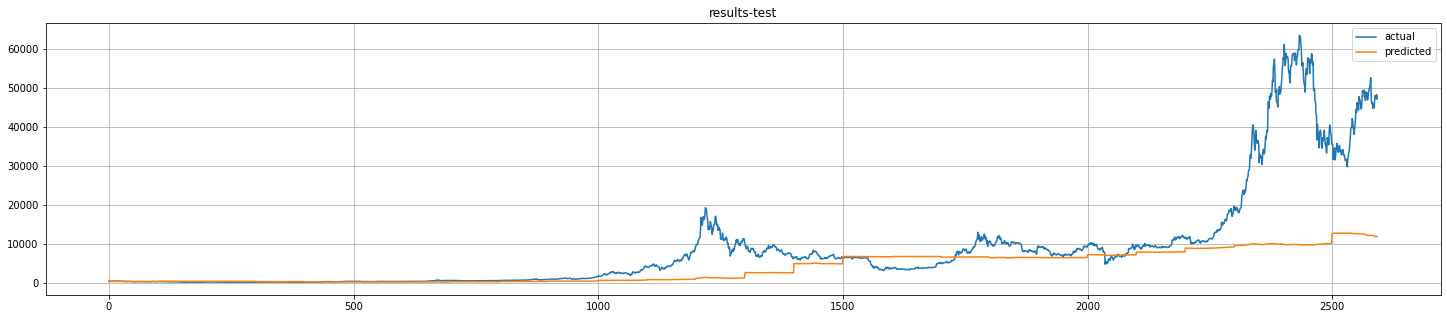

In [66]:
plot_results(lstm_y_test_array,lstm_y_test_pred_array,'results-test')

In [67]:
lstm_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,279.724323,60.603734
1,1,248.736212,186.506157
2,2,217.435413,214.157691
3,3,160.730684,130.035880
4,4,144.175181,77.412978
5,5,83.169596,130.649263
6,6,79.893537,279.236209
7,7,123.505055,280.831945
8,8,140.582217,392.514938
9,9,182.639202,684.688137


In [68]:
pd.DataFrame(lstm_result_metrics_df.mean()).drop(['batch_id'])

,0
rmse_train,2717.336636
rmse_test,5682.958298


In [69]:
# Select 8 features only #
input_layer = Input(shape=(1, 8),name='input_layer')
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = LSTM(500, return_sequences=True,activation='relu',name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)
output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError()])

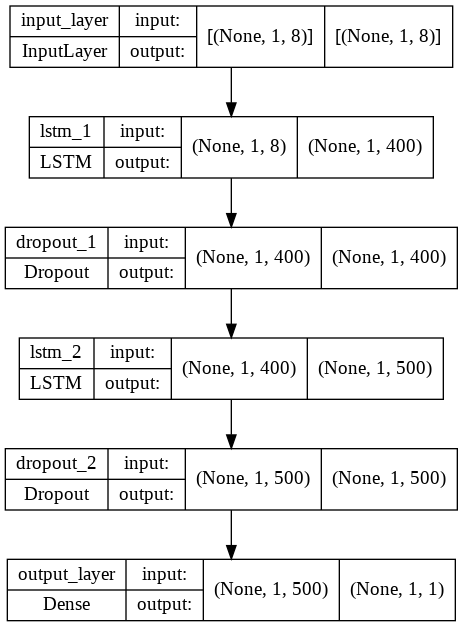

In [70]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [71]:
lstm_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lstm_result_metrics_20210922.csv')
lstm_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lstm_result_test_20210922.csv')

BILSTM

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

In [73]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [74]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [75]:
callback_list=[reduce_lr,lrschedule,earlystop]

In [76]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = Bidirectional(LSTM(400, return_sequences=True,activation='relu'),name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = Bidirectional(LSTM(500, return_sequences=True,activation='relu'),name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [77]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (Bidirectional)      (None, 1, 800)            1315200   
                                                                 
 dropout_1 (Dropout)         (None, 1, 800)            0         
                                                                 
 lstm_2 (Bidirectional)      (None, 1, 1000)           5204000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 1000)           0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              1001      
                                                                 
Total params: 6,520,201
Trainable params: 6,520,201
Non-tra

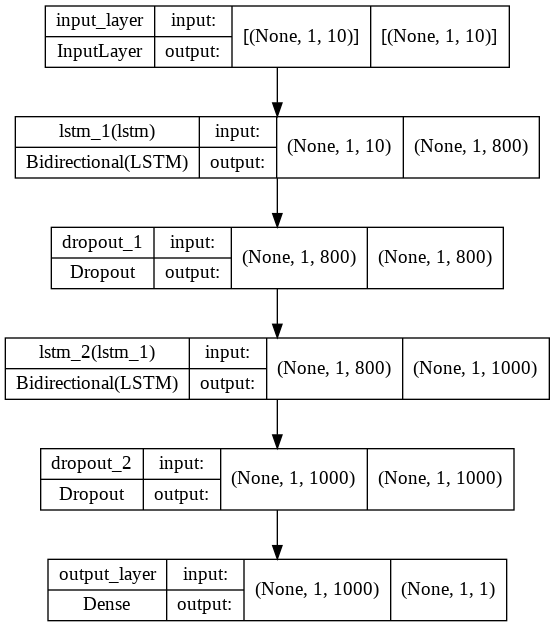

In [78]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [79]:
bilstm_date_array = []
bilstm_y_test_array = []
bilstm_y_test_pred_array = []
bilstm_batch_id_array = []
bilstm_batch_id_array_result = []
bilstm_batch_rmse_train_array = []
bilstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    pickle.dump(model, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/BILSTM1/bilstm_reg_10_{i}.sav', 'wb'))
    model.save(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/BI-LSTM/bilstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    bilstm_date_array.extend(test_splits[i]['Date'])
    bilstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    bilstm_y_test_pred_array.extend((ytest_pred.flatten()))
    bilstm_batch_id_array.extend([i]*len(test_splits[i]))
    bilstm_batch_id_array_result.append(i)
    bilstm_batch_rmse_train_array.append(RMSE_train)
    bilstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

bilstm_result_test_df = pd.DataFrame()
bilstm_result_test_df['batch_id'] = bilstm_batch_id_array
bilstm_result_test_df['Date'] = bilstm_date_array
bilstm_result_test_df['y_test'] = bilstm_y_test_array
bilstm_result_test_df['y_test_pred'] = bilstm_y_test_pred_array
bilstm_y_test_array = bilstm_result_test_df['y_test']
bilstm_y_test_pred_array = bilstm_result_test_df['y_test_pred']
bilstm_result_metrics_df = pd.DataFrame()
bilstm_result_metrics_df['batch_id'] = bilstm_batch_id_array_result
bilstm_result_metrics_df['rmse_train'] = bilstm_batch_rmse_train_array
bilstm_result_metrics_df['rmse_test'] = bilstm_batch_rmse_test_array

Batch No. 1 of 26
Train Data From 2013-04-01 - 68.4 to 2014-08-13 - 1237.6
Test Data From 2014-08-14 - 322.5 to 2014-11-21 - 522.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 411.5737 - root_mean_squared_error: 506.3876 - lr: 0.0010 - 6s/epoch - 391ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 411.0819 - root_mean_squared_error: 506.9436 - lr: 0.0010 - 1s/epoch - 76ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 409.1714 - root_mean_squared_error: 505.0473 - lr: 0.0010 - 1s/epoch - 76ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 402.6398 - root_mean_squared_error: 498.8860 - lr: 0.0010 - 1s/epoch - 78ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0009800000465475024.
Epoch 5/500
16/16 - 1s - loss: 381.8

****************************************************************************************************
Batch No. 2 of 26
Train Data From 2013-07-10 - 89.0 to 2014-11-21 - 1237.6
Test Data From 2014-11-22 - 164.9 to 2015-03-01 - 380.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 205.6314 - root_mean_squared_error: 259.7954 - lr: 0.0010 - 5s/epoch - 283ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 204.9754 - root_mean_squared_error: 258.1699 - lr: 0.0010 - 1s/epoch - 79ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 204.5462 - root_mean_squared_error: 258.2458 - lr: 0.0010 - 1s/epoch - 80ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 204.8125 - root_mean_squared_error: 258.4296 - lr: 0.0010 - 1s/epoch - 81ms/step

Epoch 5: Learn

****************************************************************************************************
Batch No. 3 of 26
Train Data From 2013-10-18 - 111.6 to 2015-03-01 - 1237.6
Test Data From 2015-03-02 - 218.0 to 2015-06-09 - 295.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 172.9606 - root_mean_squared_error: 226.0890 - lr: 0.0010 - 6s/epoch - 375ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 173.1638 - root_mean_squared_error: 224.0864 - lr: 0.0010 - 1s/epoch - 79ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 172.3702 - root_mean_squared_error: 225.4614 - lr: 0.0010 - 1s/epoch - 89ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 172.6376 - root_mean_squared_error: 226.0541 - lr: 0.0010 - 1s/epoch - 88ms/step

Epoch 5: Lear

****************************************************************************************************
Batch No. 4 of 26
Train Data From 2014-01-26 - 111.6 to 2015-06-09 - 953.3
Test Data From 2015-06-10 - 211.4 to 2015-09-17 - 310.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 142.4565 - root_mean_squared_error: 168.8251 - lr: 0.0010 - 4s/epoch - 280ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 135.7664 - root_mean_squared_error: 166.4470 - lr: 0.0010 - 1s/epoch - 79ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 135.8663 - root_mean_squared_error: 166.2925 - lr: 0.0010 - 1s/epoch - 78ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 135.2675 - root_mean_squared_error: 165.9768 - lr: 0.0010 - 1s/epoch - 88ms/step

Epoch 5: Learn

****************************************************************************************************
Batch No. 5 of 26
Train Data From 2014-05-06 - 164.9 to 2015-09-17 - 669.4
Test Data From 2015-09-18 - 226.3 to 2015-12-26 - 463.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 116.6709 - root_mean_squared_error: 139.7434 - lr: 0.0010 - 5s/epoch - 306ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 109.1868 - root_mean_squared_error: 149.4205 - lr: 0.0010 - 2s/epoch - 134ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 109.6374 - root_mean_squared_error: 154.6405 - lr: 0.0010 - 2s/epoch - 128ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 109.1386 - root_m

****************************************************************************************************
Batch No. 6 of 26
Train Data From 2014-08-14 - 164.9 to 2015-12-26 - 522.0
Test Data From 2015-12-27 - 368.0 to 2016-04-04 - 457.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 64.9907 - root_mean_squared_error: 83.6486 - lr: 0.0010 - 5s/epoch - 305ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 64.7263 - root_mean_squared_error: 89.1082 - lr: 0.0010 - 1s/epoch - 87ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 64.2285 - root_mean_squared_error: 85.3777 - lr: 0.0010 - 1s/epoch - 82ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 64.1807 - root_mean_squar

****************************************************************************************************
Batch No. 7 of 26
Train Data From 2014-11-22 - 164.9 to 2016-04-04 - 463.2
Test Data From 2016-04-05 - 417.7 to 2016-07-13 - 761.2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 63.9764 - root_mean_squared_error: 82.5139 - lr: 0.0010 - 5s/epoch - 293ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 64.5563 - root_mean_squared_error: 82.4158 - lr: 0.0010 - 1s/epoch - 81ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 64.0472 - root_mean_squared_error: 80.8997 - lr: 0.0010 - 1s/epoch - 80ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 64.1689 - root_mean_squared_error: 83.3520 - lr: 0.0010 - 1s/epoch - 82ms/step

Epoch 5: LearningRateS

****************************************************************************************************
Batch No. 8 of 26
Train Data From 2015-03-02 - 211.4 to 2016-07-13 - 761.2
Test Data From 2016-07-14 - 513.4 to 2016-10-21 - 676.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 103.5848 - root_mean_squared_error: 141.2435 - lr: 0.0010 - 5s/epoch - 296ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 102.2314 - root_mean_squared_error: 127.3188 - lr: 0.0010 - 1s/epoch - 91ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 102.4424 - root_mean_squared_error: 127.3077 - lr: 0.0010 - 1s/epoch - 90ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 102.4510 - root_mean_squared_error: 130.2996 - lr: 0.0010 - 1s/epoch - 89ms/step

Epoch 5: Learn

****************************************************************************************************
Batch No. 9 of 26
Train Data From 2015-06-10 - 211.4 to 2016-10-21 - 761.2
Test Data From 2016-10-22 - 650.5 to 2017-01-29 - 1135.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 130.4925 - root_mean_squared_error: 162.1362 - lr: 0.0010 - 4s/epoch - 281ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 120.4949 - root_mean_squared_error: 144.7980 - lr: 0.0010 - 1s/epoch - 87ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 120.3657 - root_mean_squared_error: 147.7725 - lr: 0.0010 - 1s/epoch - 84ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 119.1421 - root_mean_squared_error: 145.5615 - lr: 0.0010 - 1s/epoch - 90ms/step

Epoch 5: Lear

****************************************************************************************************
Batch No. 10 of 26
Train Data From 2015-09-18 - 226.3 to 2017-01-29 - 1135.4
Test Data From 2017-01-30 - 939.7 to 2017-05-09 - 1752.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 157.0299 - root_mean_squared_error: 201.2309 - lr: 0.0010 - 5s/epoch - 282ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 154.6824 - root_mean_squared_error: 186.7910 - lr: 0.0010 - 1s/epoch - 82ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 154.0965 - root_mean_squared_error: 184.9438 - lr: 0.0010 - 1s/epoch - 86ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 154.0859 - root_mean_squared_error: 190.3326 - lr: 0.0010 - 1s/epoch - 83ms/step

Epoch 5: Le

****************************************************************************************************
Batch No. 11 of 26
Train Data From 2015-12-27 - 368.0 to 2017-05-09 - 1752.3
Test Data From 2017-05-10 - 1686.4 to 2017-08-17 - 4387.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 235.9250 - root_mean_squared_error: 325.1695 - lr: 0.0010 - 5s/epoch - 282ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 221.4769 - root_mean_squared_error: 293.3622 - lr: 0.0010 - 1s/epoch - 87ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 220.5154 - root_mean_squared_error: 294.1582 - lr: 0.0010 - 1s/epoch - 88ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 220.3223 - root_mean_squared_error: 300.7587 - lr: 0.0010 - 1s/epoch - 84ms/step

Epoch 5: L

****************************************************************************************************
Batch No. 12 of 26
Train Data From 2016-04-05 - 417.7 to 2017-08-17 - 4387.4
Test Data From 2017-08-18 - 3243.1 to 2017-11-25 - 9318.4

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 558.6284 - root_mean_squared_error: 938.8921 - lr: 0.0010 - 5s/epoch - 282ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 551.0771 - root_mean_squared_error: 888.6529 - lr: 0.0010 - 1s/epoch - 82ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 551.8538 - root_mean_squared_error: 888.7207 - lr: 0.0010 - 1s/epoch - 83ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 551.4561 - root_mean_squared_error: 906.5696 - lr: 0.0010 - 1s/epoch - 84ms/step

Epoch 5: L

****************************************************************************************************
Batch No. 13 of 26
Train Data From 2016-07-14 - 513.4 to 2017-11-25 - 9318.4
Test Data From 2017-11-26 - 6938.5 to 2018-03-05 - 19345.5

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 1392.1163 - root_mean_squared_error: 2294.1321 - lr: 0.0010 - 6s/epoch - 366ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1351.2469 - root_mean_squared_error: 2150.6309 - lr: 0.0010 - 2s/epoch - 101ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1350.2582 - root_mean_squared_error: 2121.4316 - lr: 0.0010 - 2s/epoch - 108ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 1348.2103 - root_mean_squared_error: 2141.8950 - lr: 0.0010 - 2s/epoch - 109ms/step

****************************************************************************************************
Batch No. 14 of 26
Train Data From 2016-10-22 - 650.5 to 2018-03-05 - 19345.5
Test Data From 2018-03-06 - 6312.3 to 2018-06-13 - 9902.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 3433.7375 - root_mean_squared_error: 5521.9321 - lr: 0.0010 - 5s/epoch - 306ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 3322.0608 - root_mean_squared_error: 5220.9604 - lr: 0.0010 - 2s/epoch - 97ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 3278.7502 - root_mean_squared_error: 4921.2466 - lr: 0.0010 - 1s/epoch - 91ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 3253.0110 - root_mean_squared_error: 4918.3003 - lr: 0.0010 - 2s/epoch - 101ms/step



****************************************************************************************************
Batch No. 15 of 26
Train Data From 2017-01-30 - 939.7 to 2018-06-13 - 19345.5
Test Data From 2018-06-14 - 5883.5 to 2018-09-21 - 8407.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 3915.0757 - root_mean_squared_error: 5315.0737 - lr: 0.0010 - 5s/epoch - 308ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 3691.2991 - root_mean_squared_error: 4802.8955 - lr: 0.0010 - 2s/epoch - 102ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 3597.7368 - root_mean_squared_error: 4457.3359 - lr: 0.0010 - 2s/epoch - 102ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 3581.3269 - root_mean_squared_error: 4392.6177 - lr: 0.0010 - 2s/epoch - 113ms/step

****************************************************************************************************
Batch No. 16 of 26
Train Data From 2017-05-10 - 1686.4 to 2018-09-21 - 19345.5
Test Data From 2018-09-22 - 3228.7 to 2018-12-30 - 6705.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 3015.4207 - root_mean_squared_error: 3961.4539 - lr: 0.0010 - 5s/epoch - 323ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 2774.4829 - root_mean_squared_error: 3669.4636 - lr: 0.0010 - 2s/epoch - 110ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 2746.1084 - root_mean_squared_error: 3624.6306 - lr: 0.0010 - 2s/epoch - 115ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 2744.6230 - root_mean_squared_error: 3650.0603 - lr: 0.0010 - 2s/epoch - 124ms/ste

****************************************************************************************************
Batch No. 17 of 26
Train Data From 2017-08-18 - 3228.7 to 2018-12-30 - 19345.5
Test Data From 2018-12-31 - 3397.7 to 2019-04-09 - 5307.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 2162.5969 - root_mean_squared_error: 3209.3079 - lr: 0.0010 - 5s/epoch - 311ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2160.9463 - root_mean_squared_error: 3181.6399 - lr: 0.0010 - 1s/epoch - 91ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 2160.3420 - root_mean_squared_error: 3190.4099 - lr: 0.0010 - 2s/epoch - 97ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 2165.4675 - root_mean_squared_error: 3204.7673 - lr: 0.0010 - 2s/epoch - 98ms/step



****************************************************************************************************
Batch No. 18 of 26
Train Data From 2017-11-26 - 3228.7 to 2019-04-09 - 19345.5
Test Data From 2019-04-10 - 5022.6 to 2019-07-18 - 13063.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 2384.8601 - root_mean_squared_error: 3344.2859 - lr: 0.0010 - 6s/epoch - 378ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 2384.3582 - root_mean_squared_error: 3372.1069 - lr: 0.0010 - 2s/epoch - 120ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 2384.8245 - root_mean_squared_error: 3358.1230 - lr: 0.0010 - 2s/epoch - 109ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 2384.1265 - root_mean_squared_error: 3338.9722 - lr: 0.0010 - 2s/epoch - 103ms/st

****************************************************************************************************
Batch No. 19 of 26
Train Data From 2018-03-06 - 3228.7 to 2019-07-18 - 13063.8
Test Data From 2019-07-19 - 7422.7 to 2019-10-26 - 12191.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 1694.9312 - root_mean_squared_error: 2146.6467 - lr: 0.0010 - 6s/epoch - 372ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1693.1576 - root_mean_squared_error: 2131.4995 - lr: 0.0010 - 2s/epoch - 107ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1693.9985 - root_mean_squared_error: 2140.9902 - lr: 0.0010 - 2s/epoch - 119ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 1695.5837 - root_mean_squared_error: 2138.1426 - lr: 0.0010 - 2s/epoch - 114ms/st

****************************************************************************************************
Batch No. 20 of 26
Train Data From 2018-06-14 - 3228.7 to 2019-10-26 - 13063.8
Test Data From 2019-10-27 - 6613.3 to 2020-02-03 - 9507.3

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1989.8065 - root_mean_squared_error: 2474.5332 - lr: 0.0010 - 5s/epoch - 325ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1986.5316 - root_mean_squared_error: 2464.3325 - lr: 0.0010 - 2s/epoch - 104ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1989.2946 - root_mean_squared_error: 2465.5164 - lr: 0.0010 - 2s/epoch - 111ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 1990.8156 - root_mean_squared_error: 2473.5989 - lr: 0.0010 - 2s/epoch - 119ms/ste

****************************************************************************************************
Batch No. 21 of 26
Train Data From 2018-09-22 - 3228.7 to 2020-02-03 - 13063.8
Test Data From 2020-02-04 - 4826.0 to 2020-05-13 - 10333.0

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 2172.0664 - root_mean_squared_error: 2536.7495 - lr: 0.0010 - 5s/epoch - 308ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 2146.7087 - root_mean_squared_error: 2543.0996 - lr: 0.0010 - 2s/epoch - 99ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2151.9724 - root_mean_squared_error: 2540.7297 - lr: 0.0010 - 1s/epoch - 93ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 2s - loss: 2152.1

****************************************************************************************************
Batch No. 22 of 26
Train Data From 2018-12-31 - 3397.7 to 2020-05-13 - 13063.8
Test Data From 2020-05-14 - 8728.2 to 2020-08-21 - 12282.6

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 2003.2776 - root_mean_squared_error: 2408.3247 - lr: 0.0010 - 5s/epoch - 298ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1971.0840 - root_mean_squared_error: 2448.2754 - lr: 0.0010 - 2s/epoch - 112ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1976.7728 - root_mean_squared_error: 2435.8994 - lr: 0.0010 - 2s/epoch - 105ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 2s - loss: 1979

****************************************************************************************************
Batch No. 23 of 26
Train Data From 2019-04-10 - 4826.0 to 2020-08-21 - 13063.8
Test Data From 2020-08-22 - 10092.2 to 2020-11-29 - 19698.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1455.7307 - root_mean_squared_error: 1809.2682 - lr: 0.0010 - 5s/epoch - 313ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1378.7042 - root_mean_squared_error: 1753.1392 - lr: 0.0010 - 2s/epoch - 100ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1374.6750 - root_mean_squared_error: 1711.3403 - lr: 0.0010 - 2s/epoch - 96ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 1373.1860 - root_mean_squared_error: 1728.5754 - lr: 0.0010 - 2s/epoch - 109ms/st

****************************************************************************************************
Batch No. 24 of 26
Train Data From 2019-07-19 - 4826.0 to 2020-11-29 - 19698.1
Test Data From 2020-11-30 - 18023.6 to 2021-03-09 - 57433.8

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1716.4250 - root_mean_squared_error: 2502.0347 - lr: 0.0010 - 5s/epoch - 308ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 1703.1466 - root_mean_squared_error: 2448.2686 - lr: 0.0010 - 2s/epoch - 97ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 1692.3822 - root_mean_squared_error: 2448.0930 - lr: 0.0010 - 2s/epoch - 98ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 1687.0980 - root_mean_squared_error: 2447.7781 - lr: 0.0010 - 2s/epoch - 108ms/ste

****************************************************************************************************
Batch No. 25 of 26
Train Data From 2019-10-27 - 4826.0 to 2021-03-09 - 57433.8
Test Data From 2021-03-10 - 33382.9 to 2021-06-17 - 63540.9

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 6696.3179 - root_mean_squared_error: 12971.1172 - lr: 0.0010 - 5s/epoch - 312ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 2s - loss: 6693.5869 - root_mean_squared_error: 12834.3545 - lr: 0.0010 - 2s/epoch - 98ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 2s - loss: 6687.1416 - root_mean_squared_error: 12827.0400 - lr: 0.0010 - 2s/epoch - 96ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 6688.0156 - root_mean_squared_error: 12756.8818 - lr: 0.0010 - 2s/epoch - 108ms

****************************************************************************************************
Batch No. 26 of 26
Train Data From 2020-02-04 - 4826.0 to 2021-06-17 - 63540.9
Test Data From 2021-06-18 - 29793.8 to 2021-09-18 - 52672.1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 14168.9424 - root_mean_squared_error: 21963.8496 - lr: 0.0010 - 5s/epoch - 300ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 14016.2773 - root_mean_squared_error: 21083.5957 - lr: 0.0010 - 1s/epoch - 92ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 14030.2764 - root_mean_squared_error: 20954.3398 - lr: 0.0010 - 1s/epoch - 93ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 2s - loss: 13994.7383 - root_mean_squared_error: 21099.7090 - lr: 0.0010 - 2s/epoch - 1

****************************************************************************************************


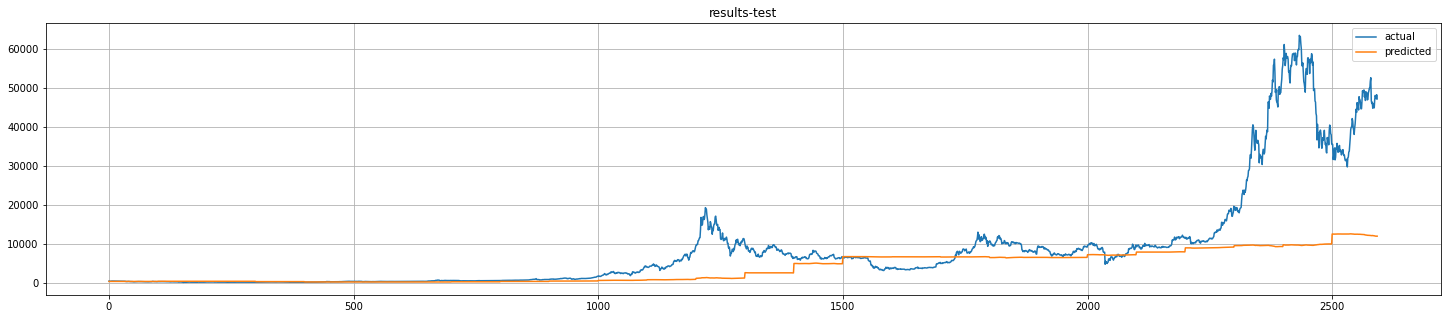

In [80]:
plot_results(bilstm_y_test_array,bilstm_y_test_pred_array,'results-test')

In [81]:
bilstm_result_metrics_df

,batch_id,rmse_train,rmse_test
0,0,280.947962,60.858819
1,1,251.043183,187.428406
2,2,218.716634,214.286511
3,3,161.230348,126.243370
4,4,146.968417,80.227855
5,5,84.880589,135.365308
6,6,77.516227,272.955710
7,7,122.808159,279.838986
8,8,140.216545,390.611410
9,9,178.275186,666.790770


In [82]:
pd.DataFrame(bilstm_result_metrics_df.mean()).drop(['batch_id'])

,0
rmse_train,2721.532674
rmse_test,5698.885529


In [83]:
bilstm_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/bilstm_result_metrics_20210922.csv')
bilstm_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/bilstm_result_test_20210922.csv')